In [1]:
# Imports - run first
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import rc
rc("pdf", fonttype=42)

from geoscripts.dz import dz

samples_published = dz.load_all()

samples_new = dz.load_all('UCD22/')


samples = samples_published + samples_new

def plot_fault_block(smps,save=False,filename=None,mda=True,plot_mapped=False,**kwargs):
    
    nplots = len(smps)
    height = nplots*1.5
    
    
    if len(smps)==1:
        fig,axs = plt.subplots(nplots,dpi=300,figsize=(7.5,height))
        smp = smps[0]
        smp.kde(ax=axs,**kwargs)
        axs.set_title(smp.name)
        axs.set_xlim(50,4000)

        if mda:
            mda_text = 'MDA: ' + str(round(smp.mda,1)) + ' ± ' + str(round(smp.mda_err,1))
            axs.text(0.02,0.3,mda_text,transform=axs.transAxes)
            ysg_text = 'YSG: ' + str(round(smp.ysg,1)) + ' ± ' + str(round(smp.ysg_err,1))
            axs.text(0.02,0.1,ysg_text,transform=axs.transAxes)
    
    else:
        fig,axs = plt.subplots(nplots,dpi=300,figsize=(7.5,height),sharex=True)
        for k,smp in enumerate(smps):
            smp.kde(ax=axs[k],**kwargs)
            axs[k].set_title(smp.name)
            axs[k].set_xlim(50,4000)
            
            if mda:
                mda_text = 'MDA: ' + str(round(smp.mda,1)) + ' ± ' + str(round(smp.mda_err,1))
                axs[k].text(0.02,0.3,mda_text,transform=axs[k].transAxes)
                ysg_text = 'YSG: ' + str(round(smp.ysg,1)) + ' ± ' + str(round(smp.ysg_err,1))
                axs[k].text(0.02,0.1,ysg_text,transform=axs[k].transAxes)

            if plot_mapped:
                trans = axs[k].get_xaxis_transform()
                axs[k].plot([smp.mapped_age[0],smp.mapped_age[1]],[0.02,0.02],color='gray',linewidth=2,clip_on=False,transform=trans)
                axs[k].set_ylim(bottom=0)

    plt.tight_layout()
    
    if save == True:
        fig.savefig(filename)
    
    return(smps)

In [2]:
#Assign mapped ages
map_data = pd.read_csv('map_ages.csv')
age_cols = ['50K Min','50K Max','200K Min','200K Max','500k Min','500K Max','N Min','N Max']
ages = map_data[age_cols]
ages.index = map_data['Sample Number']

for smp in samples:
    if smp.name in ages.index:
        minmap = np.min(ages.loc[smp.name,:])
        maxmap = np.max(ages.loc[smp.name,:])
        smp.mapped_age = (minmap,maxmap)
        print(smp.name,smp.mapped_age)



N1 (419.2, 2500.0)
N2 (382.7, 433.4)
N3 (201.3, 346.7)
N5 (174.1, 201.3)
NW-GC (174.1, 201.3)
100211-1A (129.4, 163.5)
100211-9A (174.1, 201.3)
100411-5 (168.3, 170.3)
AB0913 (182.7, 190.8)
AB0926 (145.0, 201.3)
CT130918-2A (174.1, 201.3)
CT130918-9A (182.7, 199.3)
CT130919-5A (174.1, 182.7)
CT130919-8A (168.3, 170.3)
CT15076 (170.3, 182.7)
CT15082 (132.9, 163.5)
CT15092 (100.5, 145.0)
CT15099 (66.0, 100.5)
CT15113 (66.0, 100.5)
CT15127 (100.5, 145.0)


In [3]:
nickname_dic = {'CT15076':'KZ1','CT15082':'KZ2','CT15092':'KZ3','CT15099':'KZ4','CT15127':'KZ5','CT15113':'KZ6','AB0913':'RU1','CT130918-2A':'SV1',
'100211-9A':'SV2','CT130918-9A':'SV3','CT130919-5A':'SV4','100411-5':'SV5','CT130919-8A':'SV6','AB0926':'SV7','100211-1A':'SV8'}

for smp in samples:
    if smp.name in nickname_dic:
        smp.original = smp.name
        smp.name = nickname_dic[smp.name]

        # Purge erroneous ages
        smp.bestage = smp.bestage[smp.bestage>1]

        print(smp.name,smp.original)



SV8 100211-1A
SV2 100211-9A
SV5 100411-5
RU1 AB0913
SV7 AB0926
SV1 CT130918-2A
SV3 CT130918-9A
SV4 CT130919-5A
SV6 CT130919-8A
KZ1 CT15076
KZ2 CT15082
KZ3 CT15092
KZ4 CT15099
KZ6 CT15113
KZ5 CT15127


In [4]:
# Block out and sort

kz_samples = [smp for smp in samples if 'KZ' in smp.name]
kz_samples.sort(key=lambda x: x.name, reverse=True)
sv_samples = [smp for smp in samples if 'SV' in smp.name]
sv_samples.sort(key=lambda x: x.name, reverse=True)

In [5]:
# Color Svaneti samples
for smp in sv_samples:
    if smp.name=='SV1':
        smp.color='red'
    elif smp.name in ['SV2','SV3']:
        smp.color='purple'
    elif smp.name in ['SV7']:
        smp.color='skyblue'

# Color Kazbegi samples
for smp in kz_samples:
    if smp.name=='KZ1':
        smp.color='skyblue'

In [6]:
# Get single-grain MDAs

for smp in sv_samples:
    age_errors = pd.concat([smp.bestage,smp.besterror],axis=1).dropna(how='any')
    ages_sorted = age_errors.sort_values(by=['Best Age'],ignore_index=True)
    smp.ysg = ages_sorted.iloc[0,0]
    smp.ysg_err = ages_sorted.iloc[0,1]

for smp in kz_samples:
    age_errors = pd.concat([smp.bestage,smp.besterror],axis=1).dropna(how='any')
    ages_sorted = age_errors.sort_values(by=['Best Age'],ignore_index=True)
    smp.ysg = ages_sorted.iloc[0,0]
    smp.ysg_err = ages_sorted.iloc[0,1]




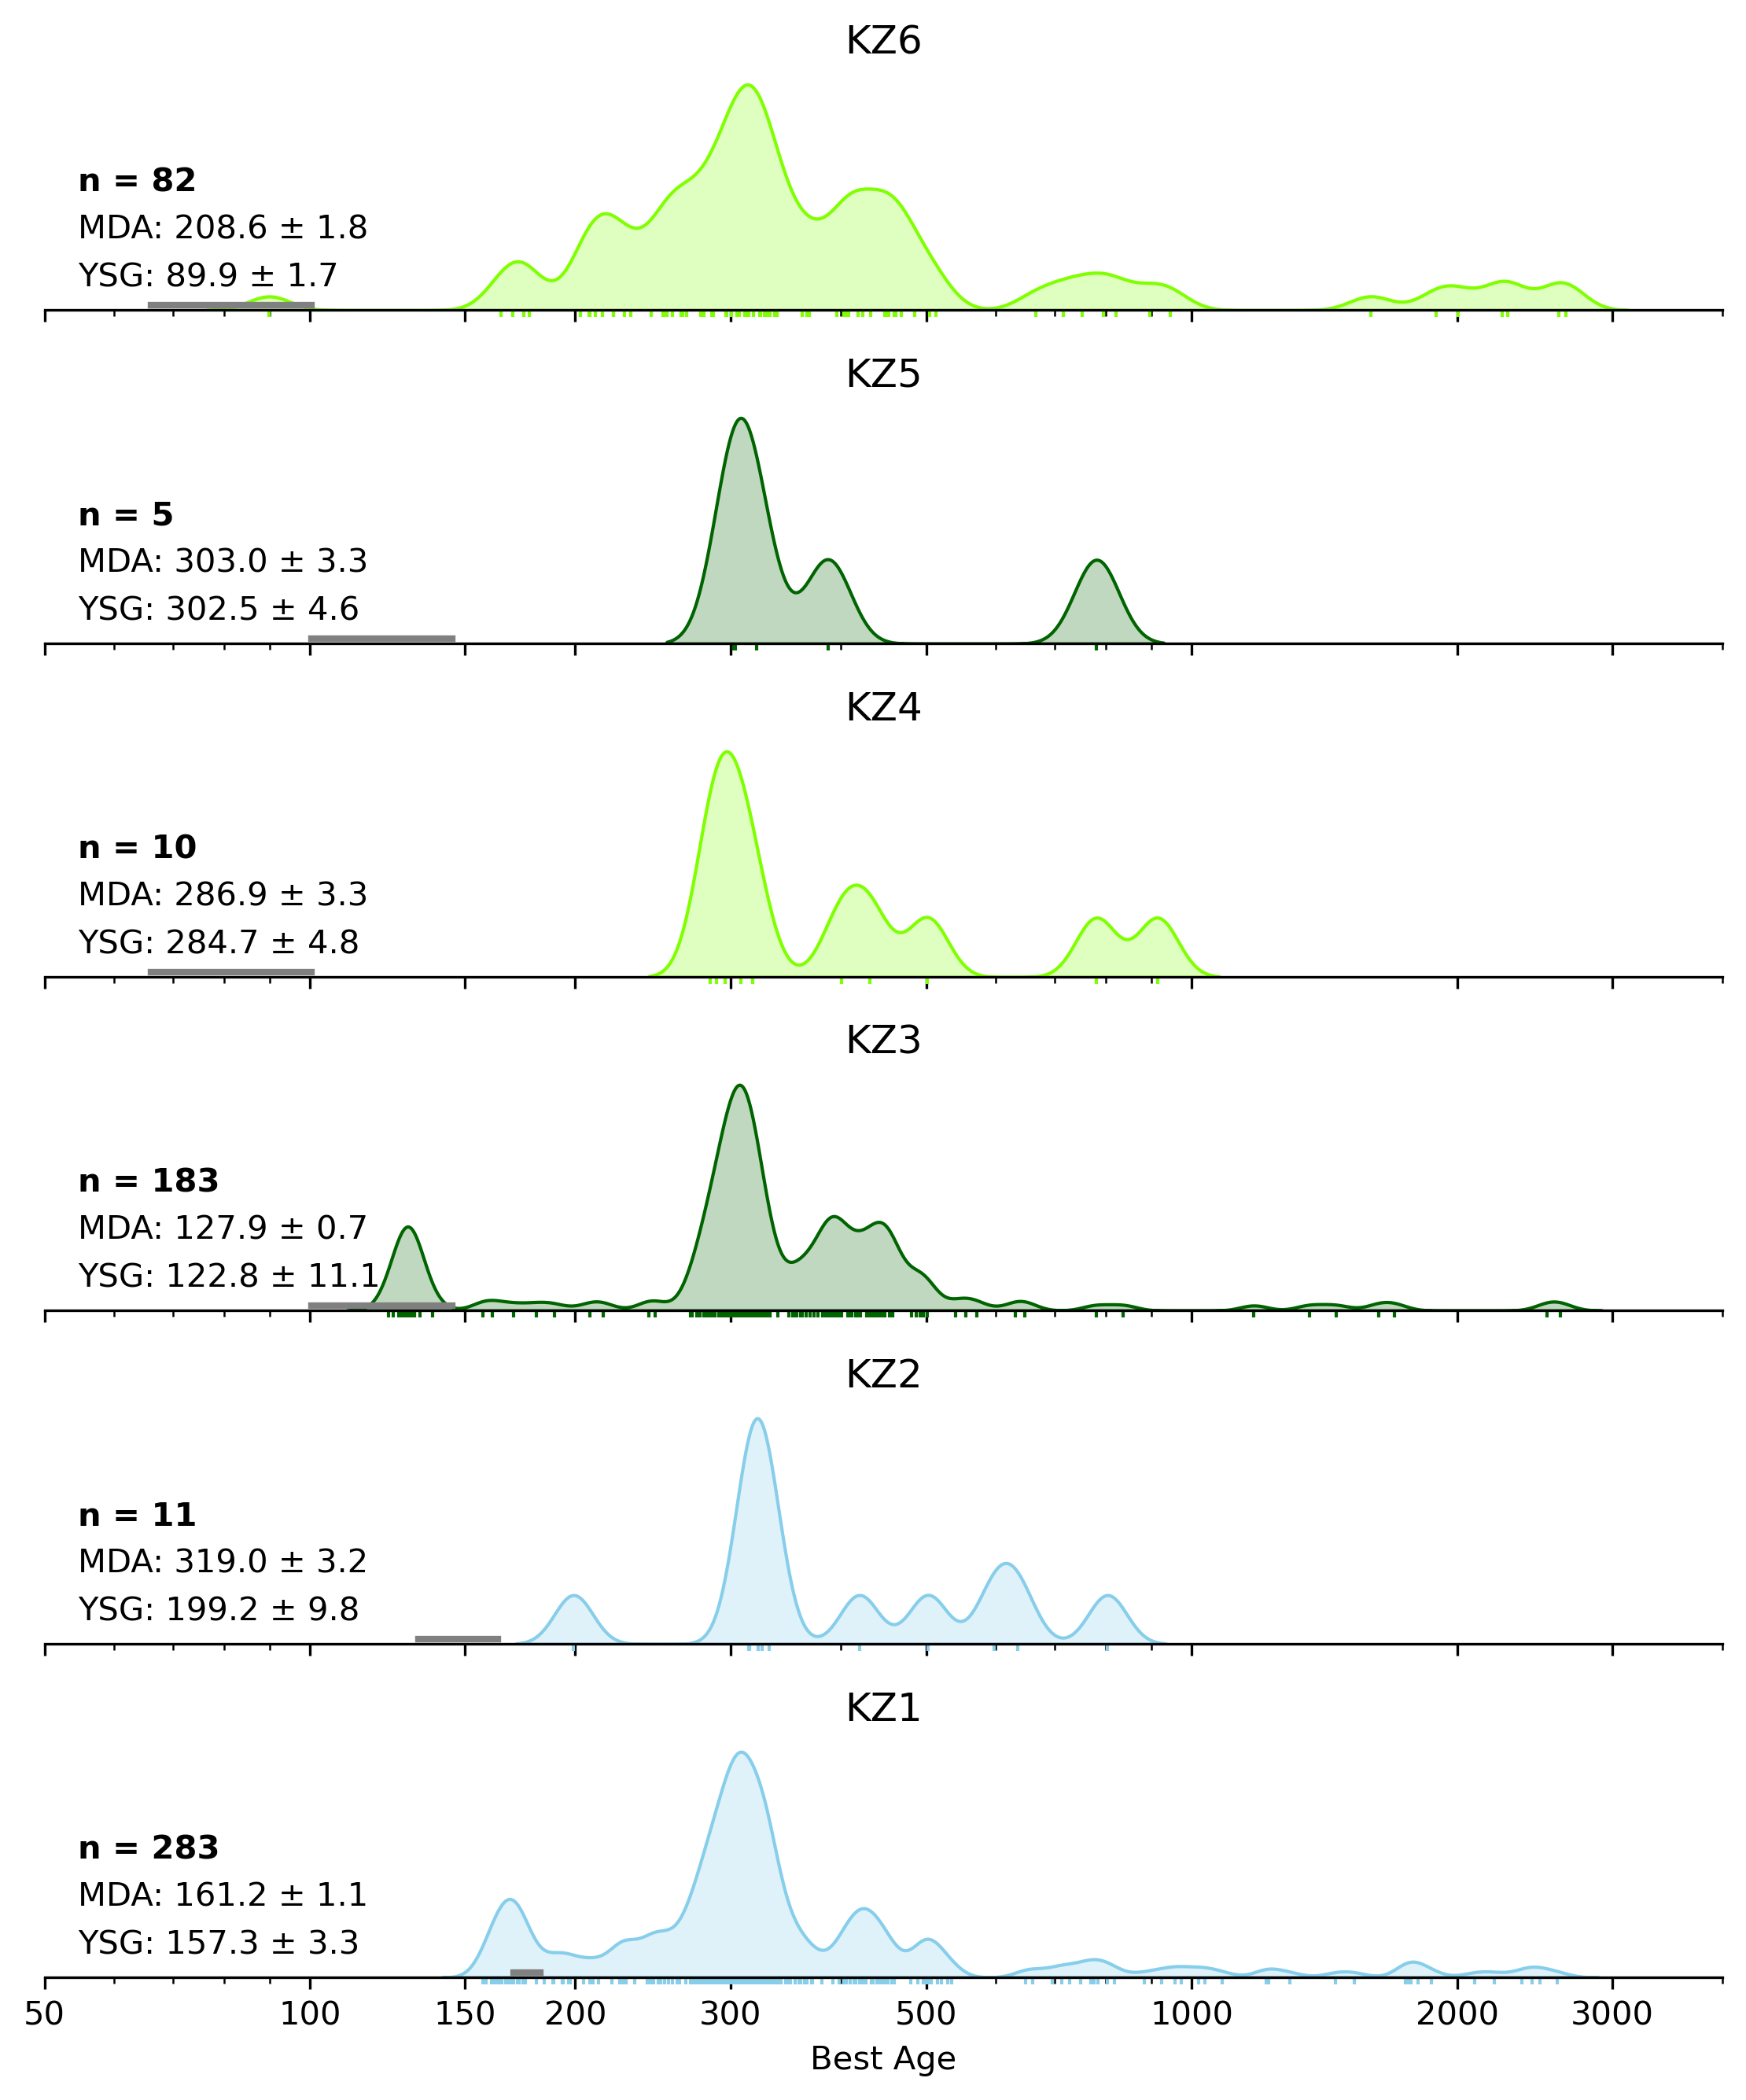

In [7]:
ticks = [50,100,150,200,300,500,1000,2000,3000]

# Plot KZ
plot_fault_block(kz_samples,save=True,filename='kz.pdf',method=None,bw_adjust=0.2,ticks=ticks,plot_mapped=True)

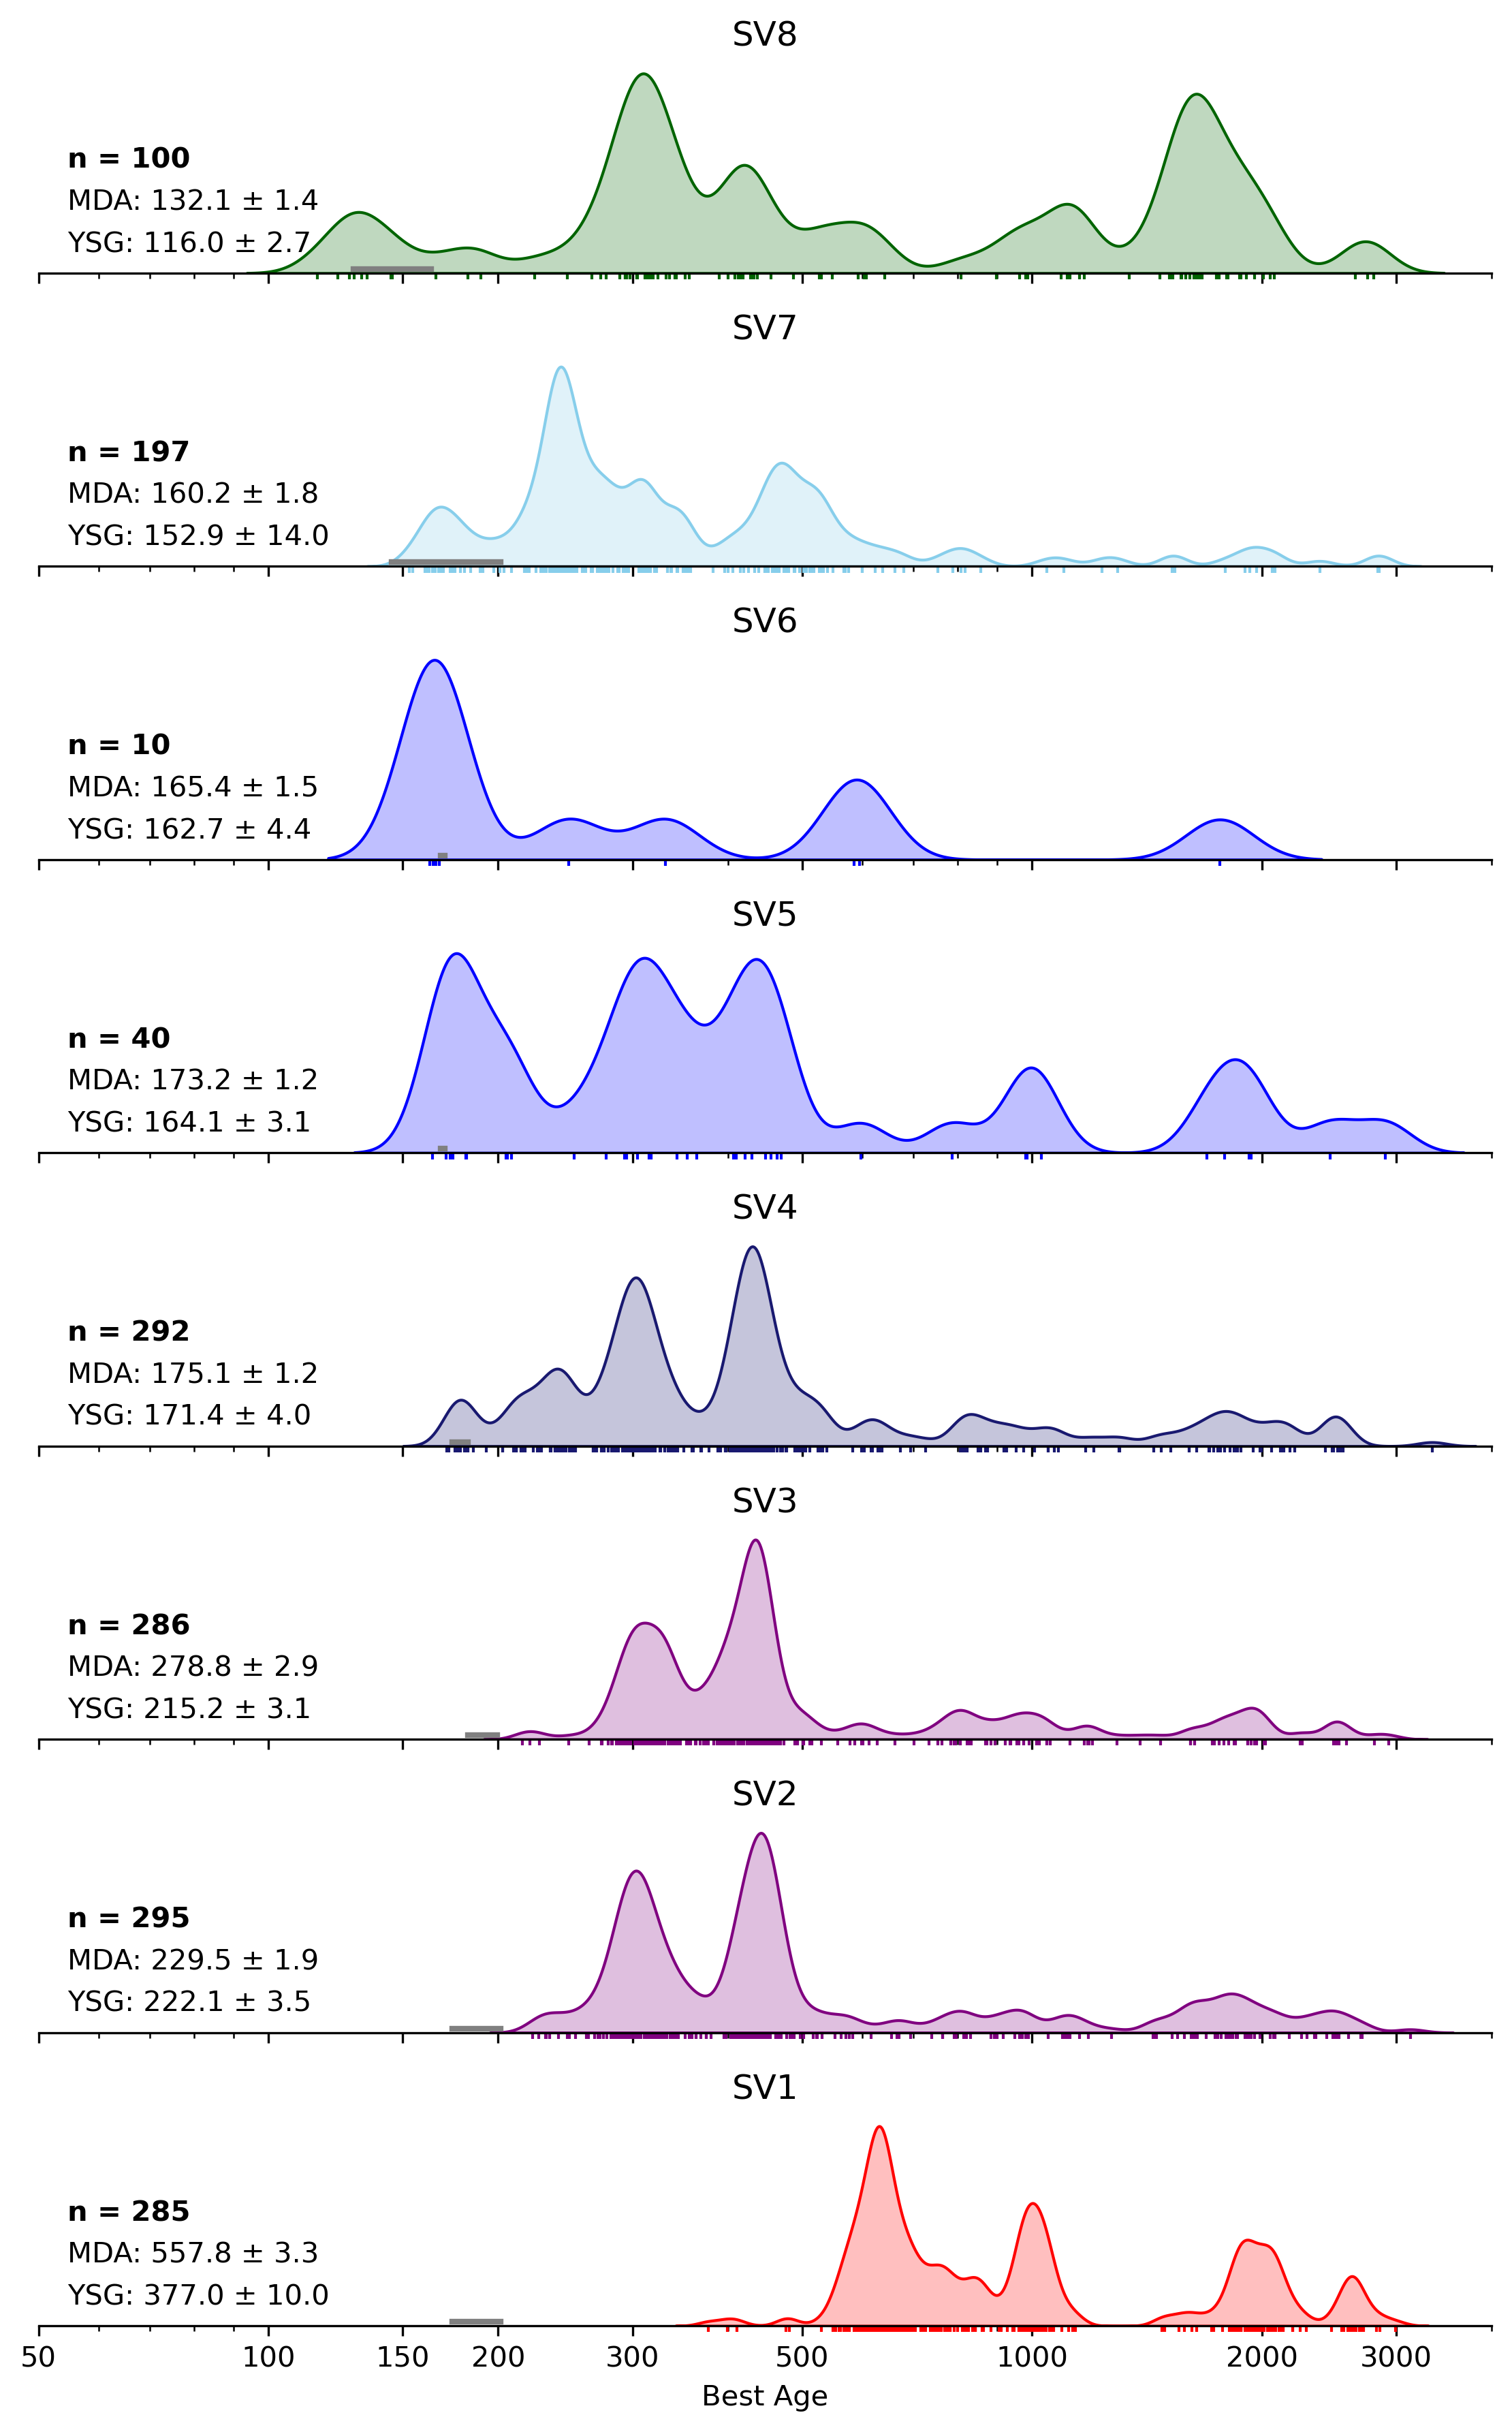

In [8]:
# Plot SV
plot_fault_block(sv_samples,save=True,filename='sv.pdf',method=None,bw_adjust=0.2,ticks=ticks,plot_mapped=True)

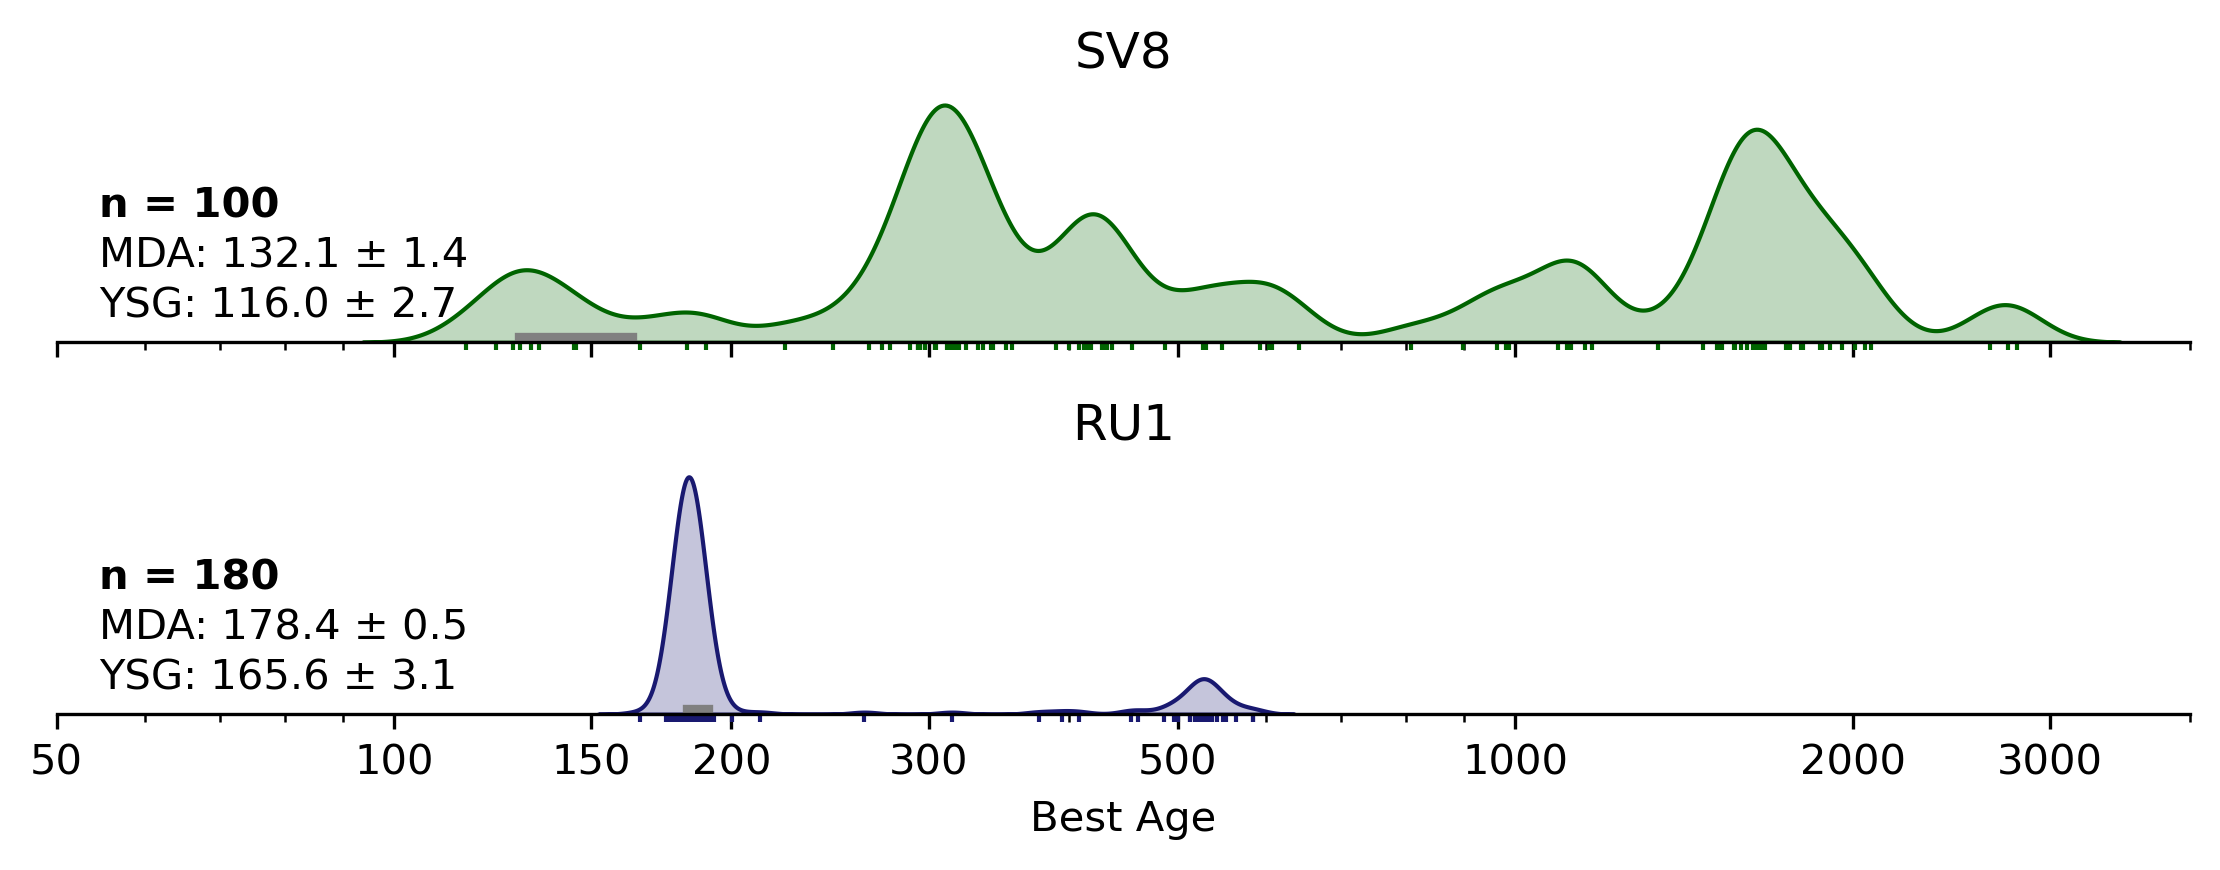

In [9]:
# Plot RU
ru = [smp for smp in samples if 'RU' in smp.name]

for smp in ru:
    age_errors = pd.concat([smp.bestage,smp.besterror],axis=1).dropna(how='any')    
    ages_sorted = age_errors.sort_values(by=['Best Age'],ignore_index=True)
    smp.ysg = ages_sorted.iloc[0,0]
    smp.ysg_err = ages_sorted.iloc[0,1]

plot_fault_block([sv_samples[0],ru[0]],save=True,filename='ru.pdf',method=None,bw_adjust=0.2,ticks=ticks,plot_mapped=True)

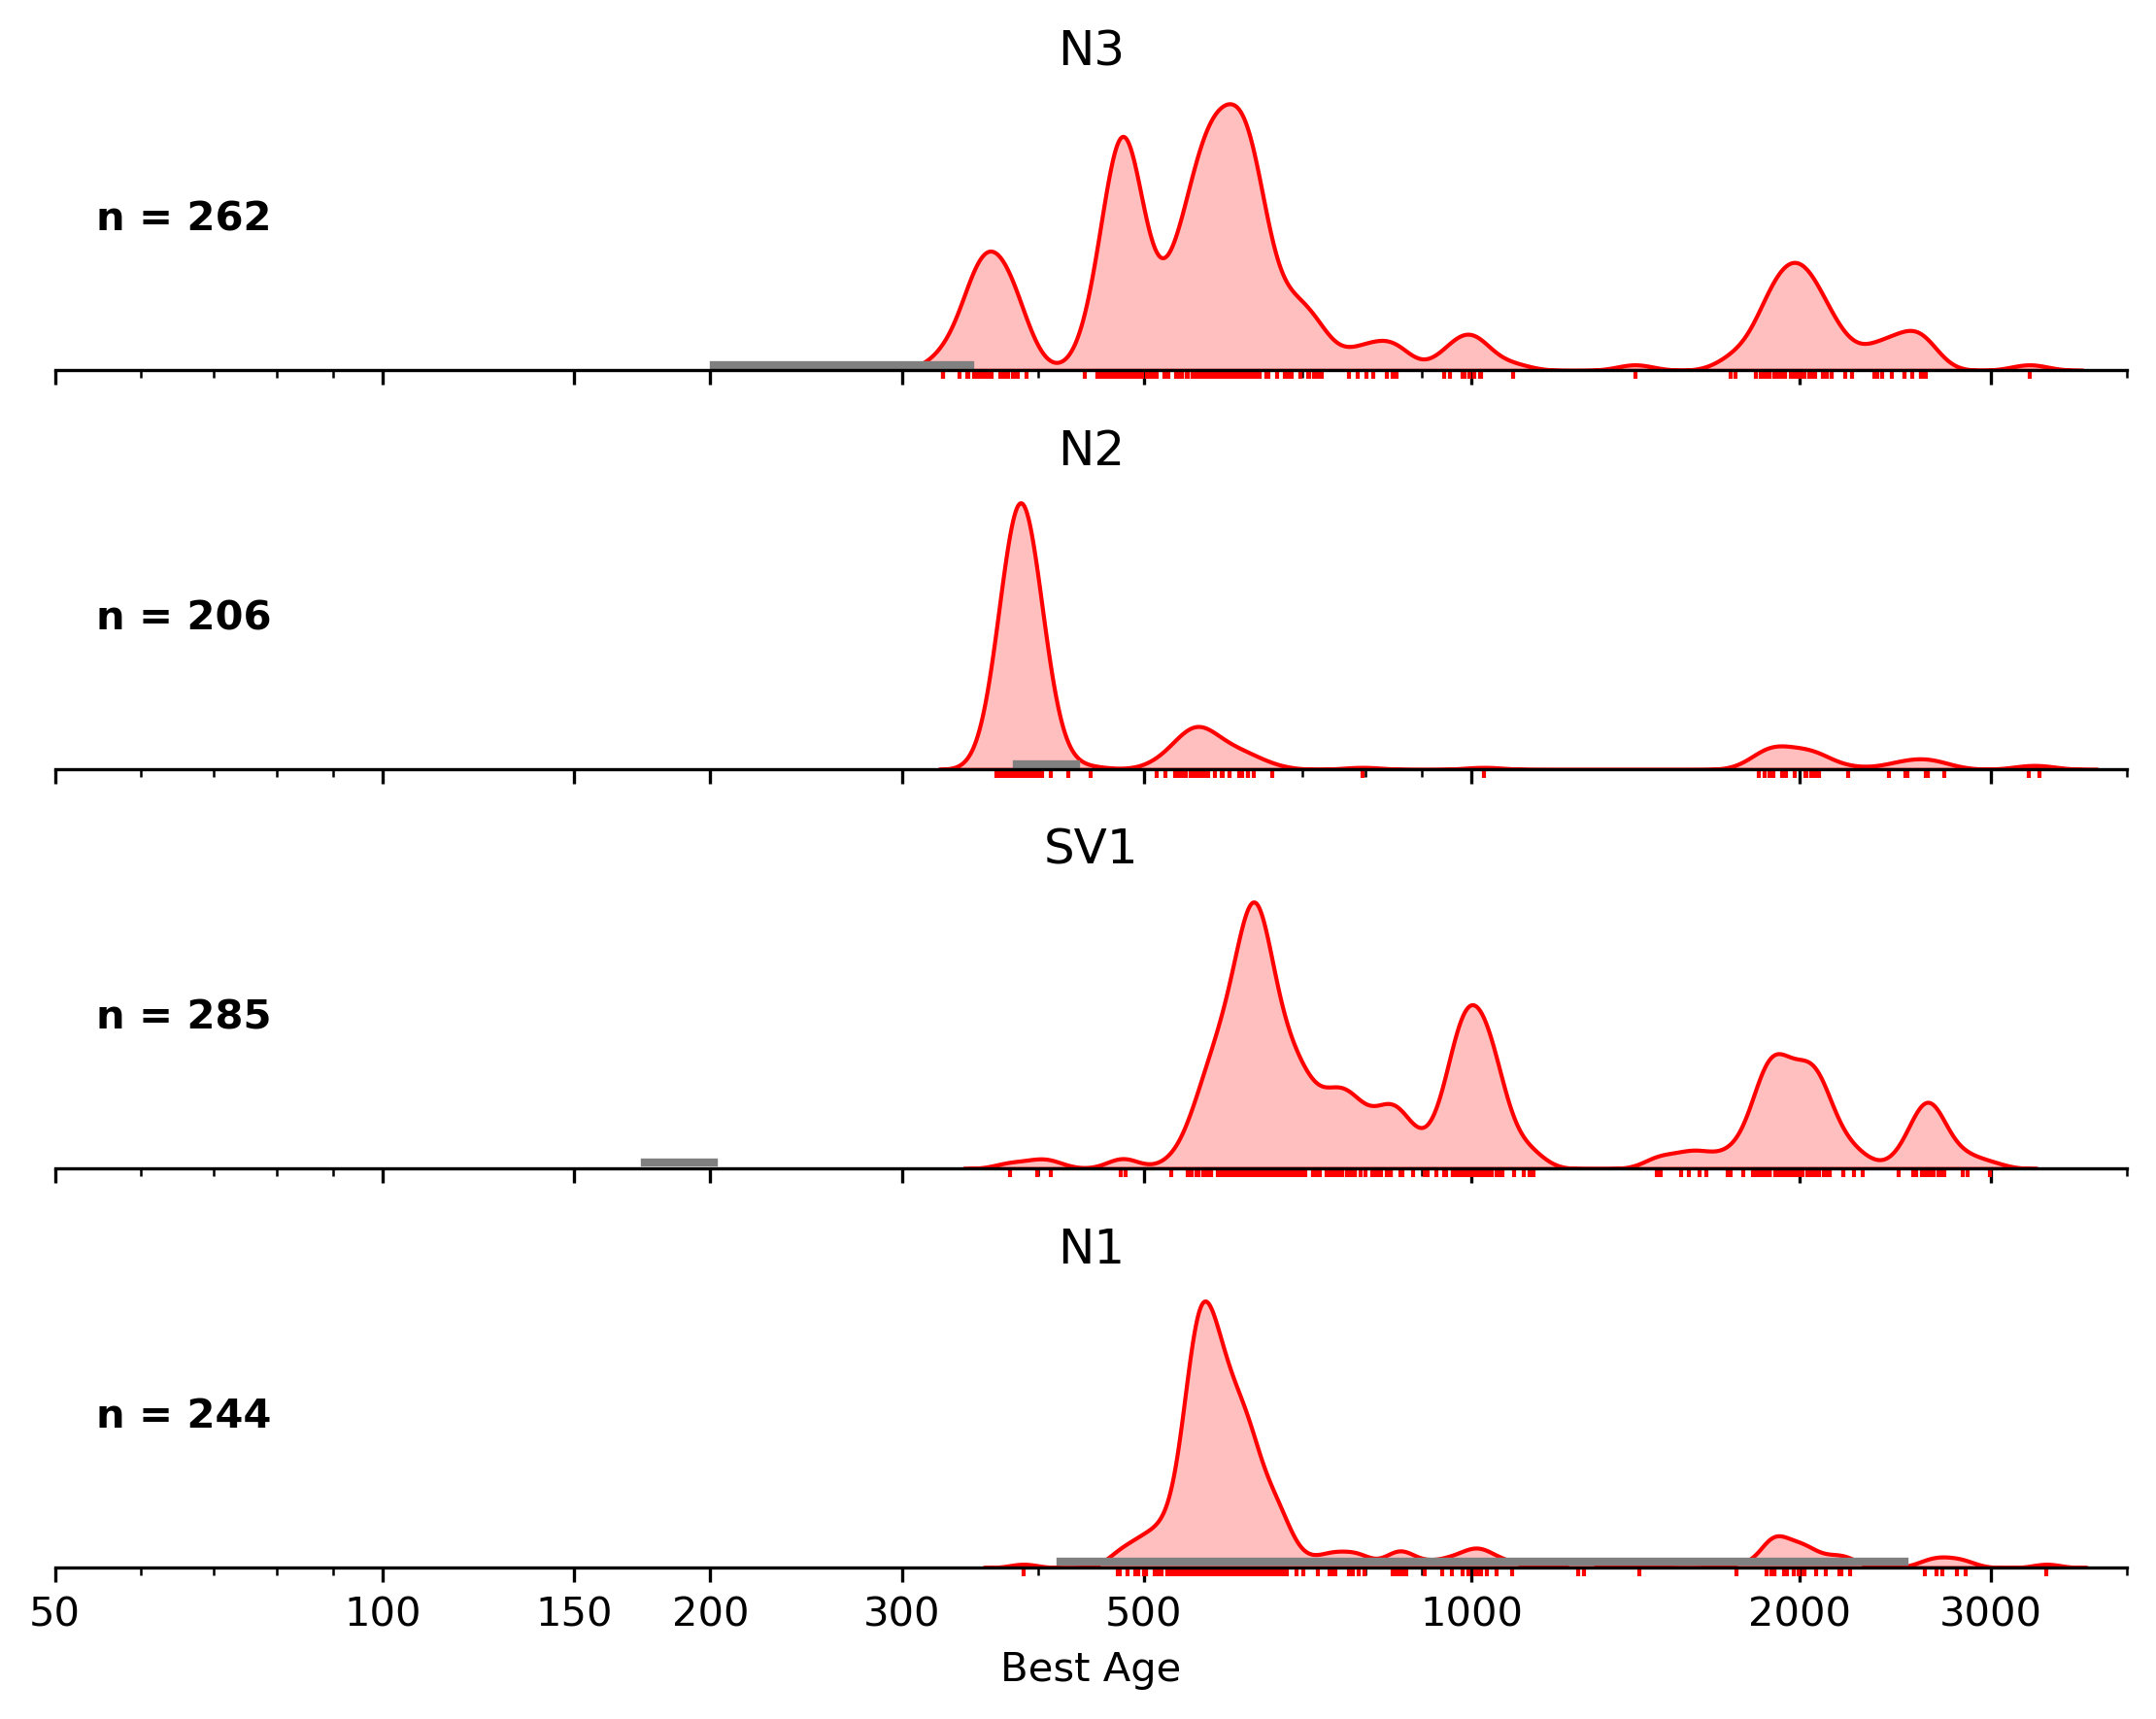

In [10]:
# Pz samples
pz1 = [smp for smp in sv_samples if smp.name=='SV1']
pz2 = [smp for smp in samples_published if smp.name in ['N1','N2','N3']]
pz = pz1+pz2

pz.sort(key=lambda x: np.min(x.bestage))

for smp in pz:
    smp.color='red'
plot_fault_block(pz,save=True,filename='pz.pdf',method=None,mda=False,bw_adjust=0.2,ticks=ticks,plot_mapped=True)

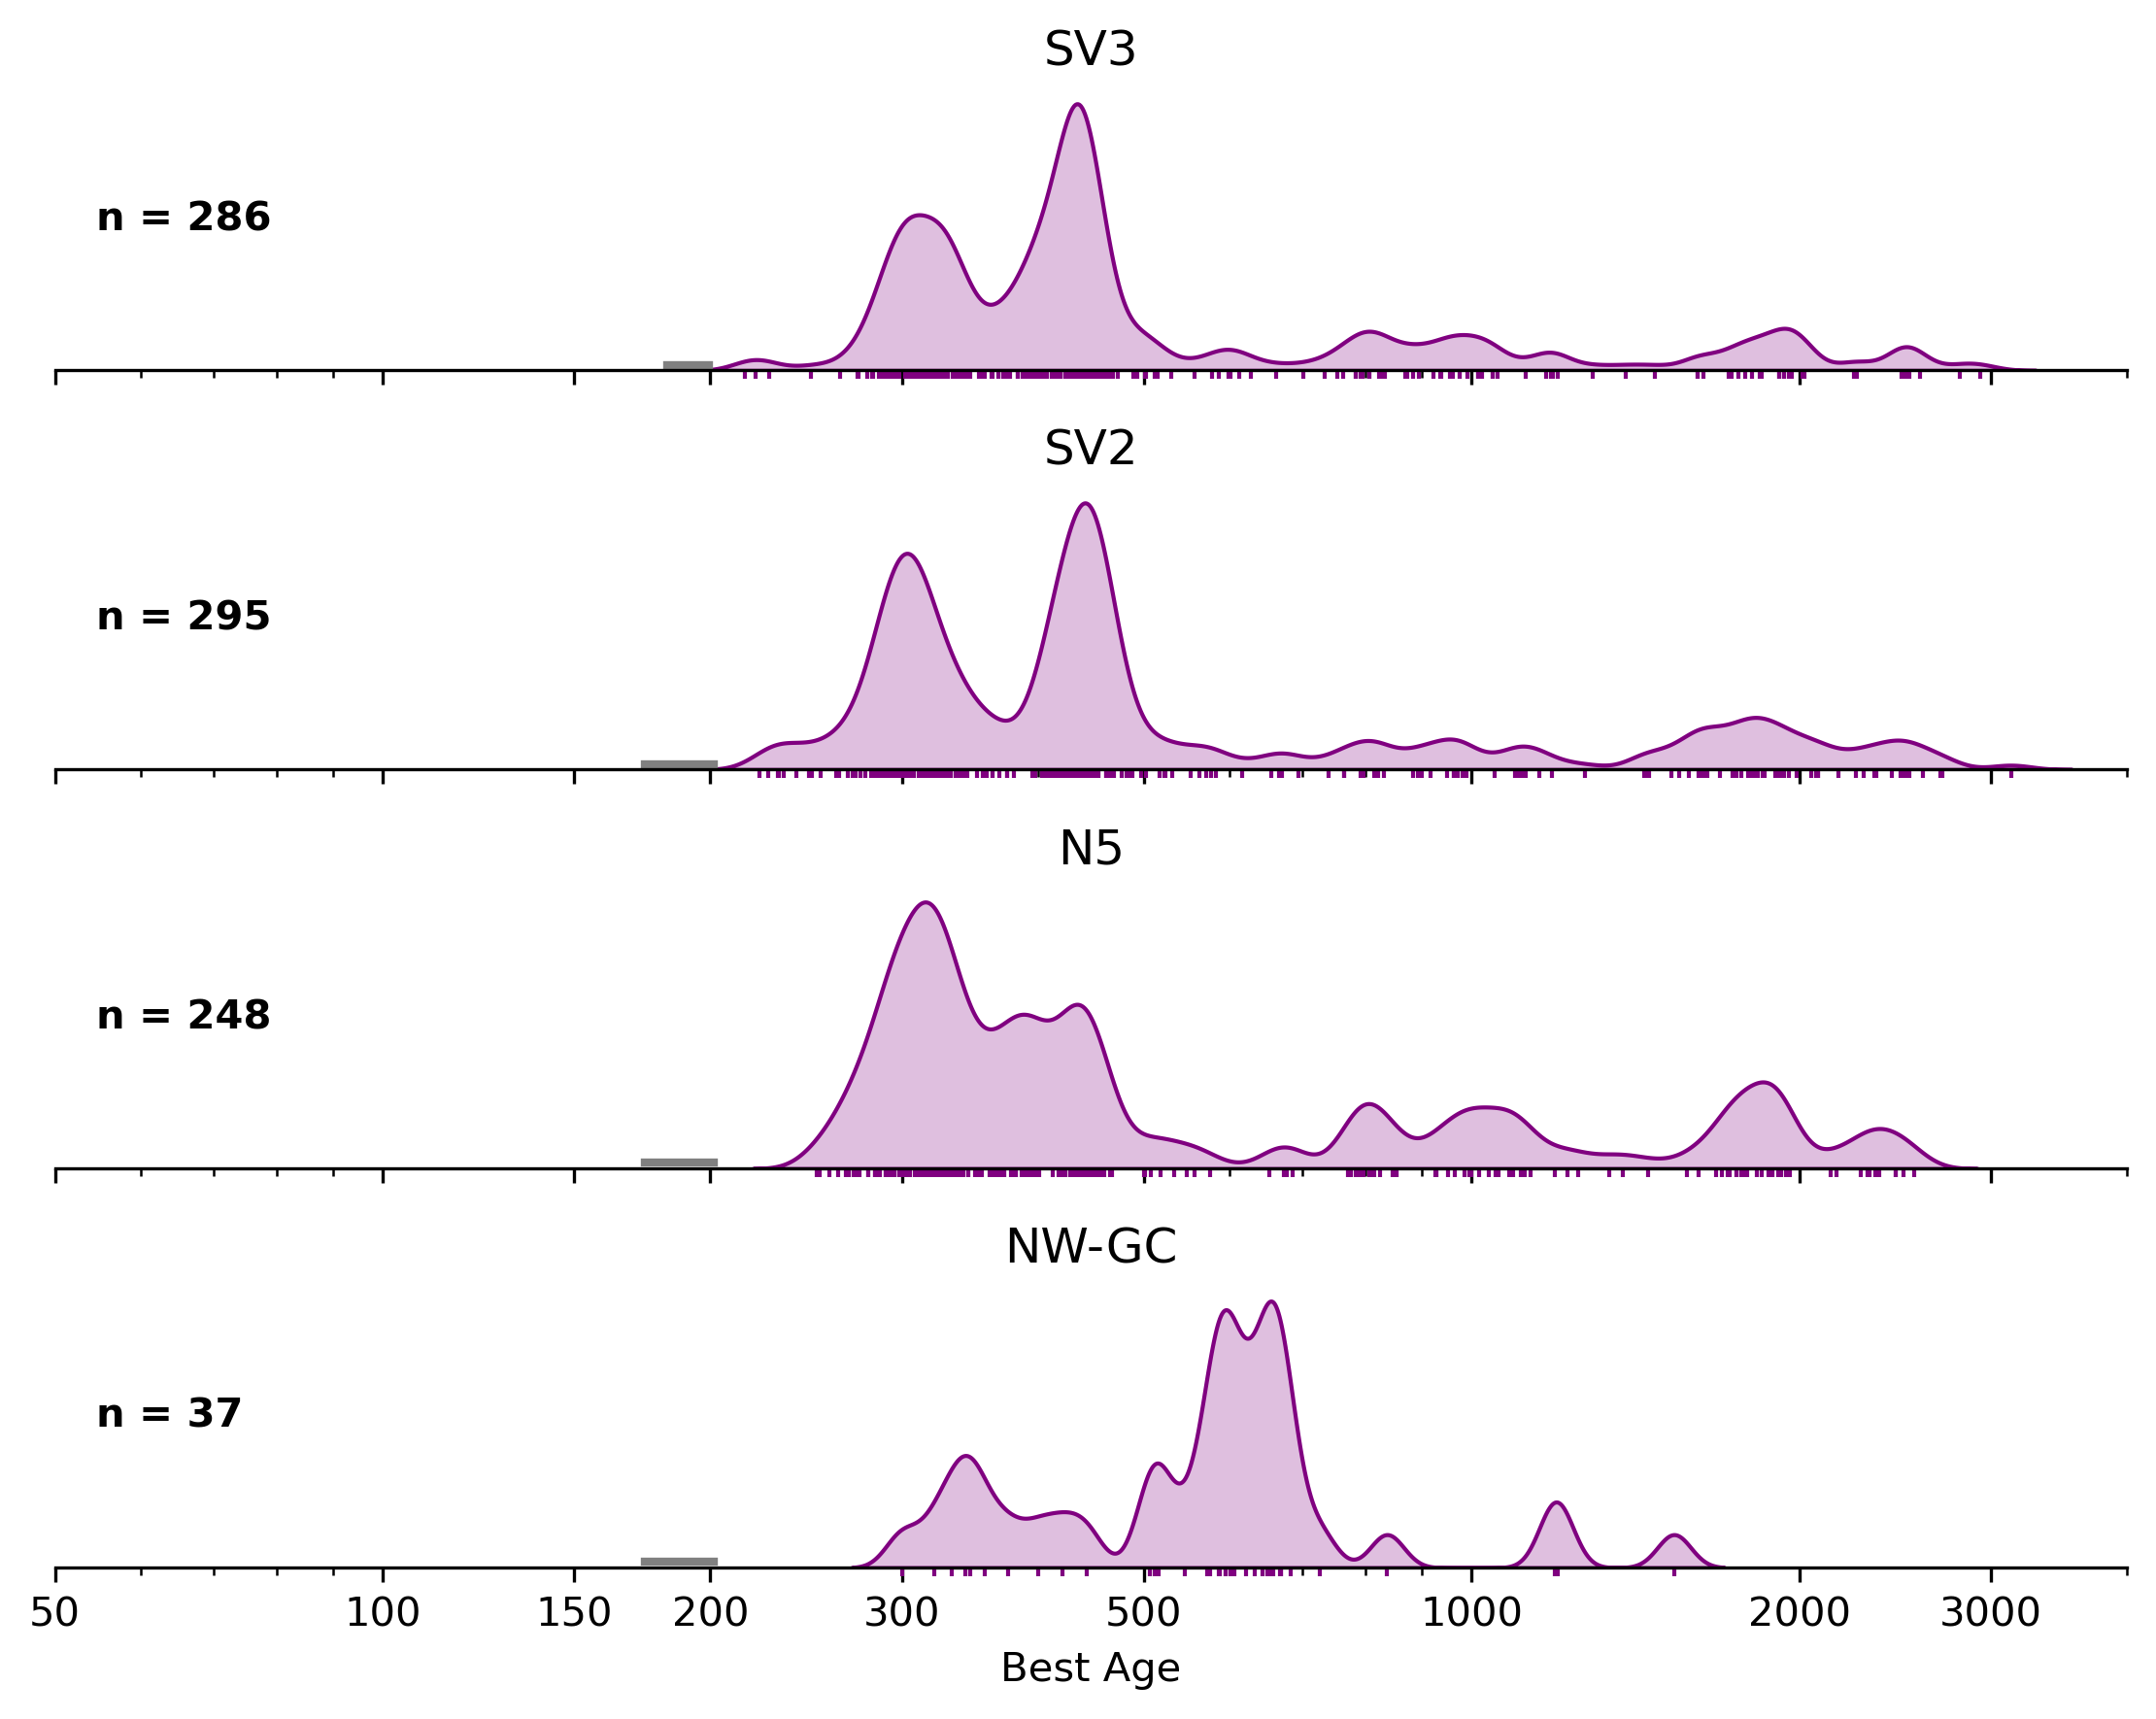

In [11]:
# P-Tr samples
tr1 = [smp for smp in sv_samples if smp.name in ['SV2','SV3']]
tr2 = [smp for smp in samples_published if smp.name in ['N5','NW-GC']]
tr = tr1+tr2

tr.sort(key=lambda x: np.min(x.bestage))

for smp in tr:
    smp.color='purple'
plot_fault_block(tr,save=True,filename='tr.pdf',method=None,mda=False,bw_adjust=0.2,ticks=ticks,plot_mapped=True)

c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:559: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  comp.bestage = pd.Series()
c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:564: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp.bestage = comp.bestage.append(sample.bestage)
c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:564: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp.bestage = comp.bestage.append(sample.bestage)
c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:564: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp.bestage = comp.bestage.append(sample.bestage)
c:\Users\dyvas\git\dz-cau

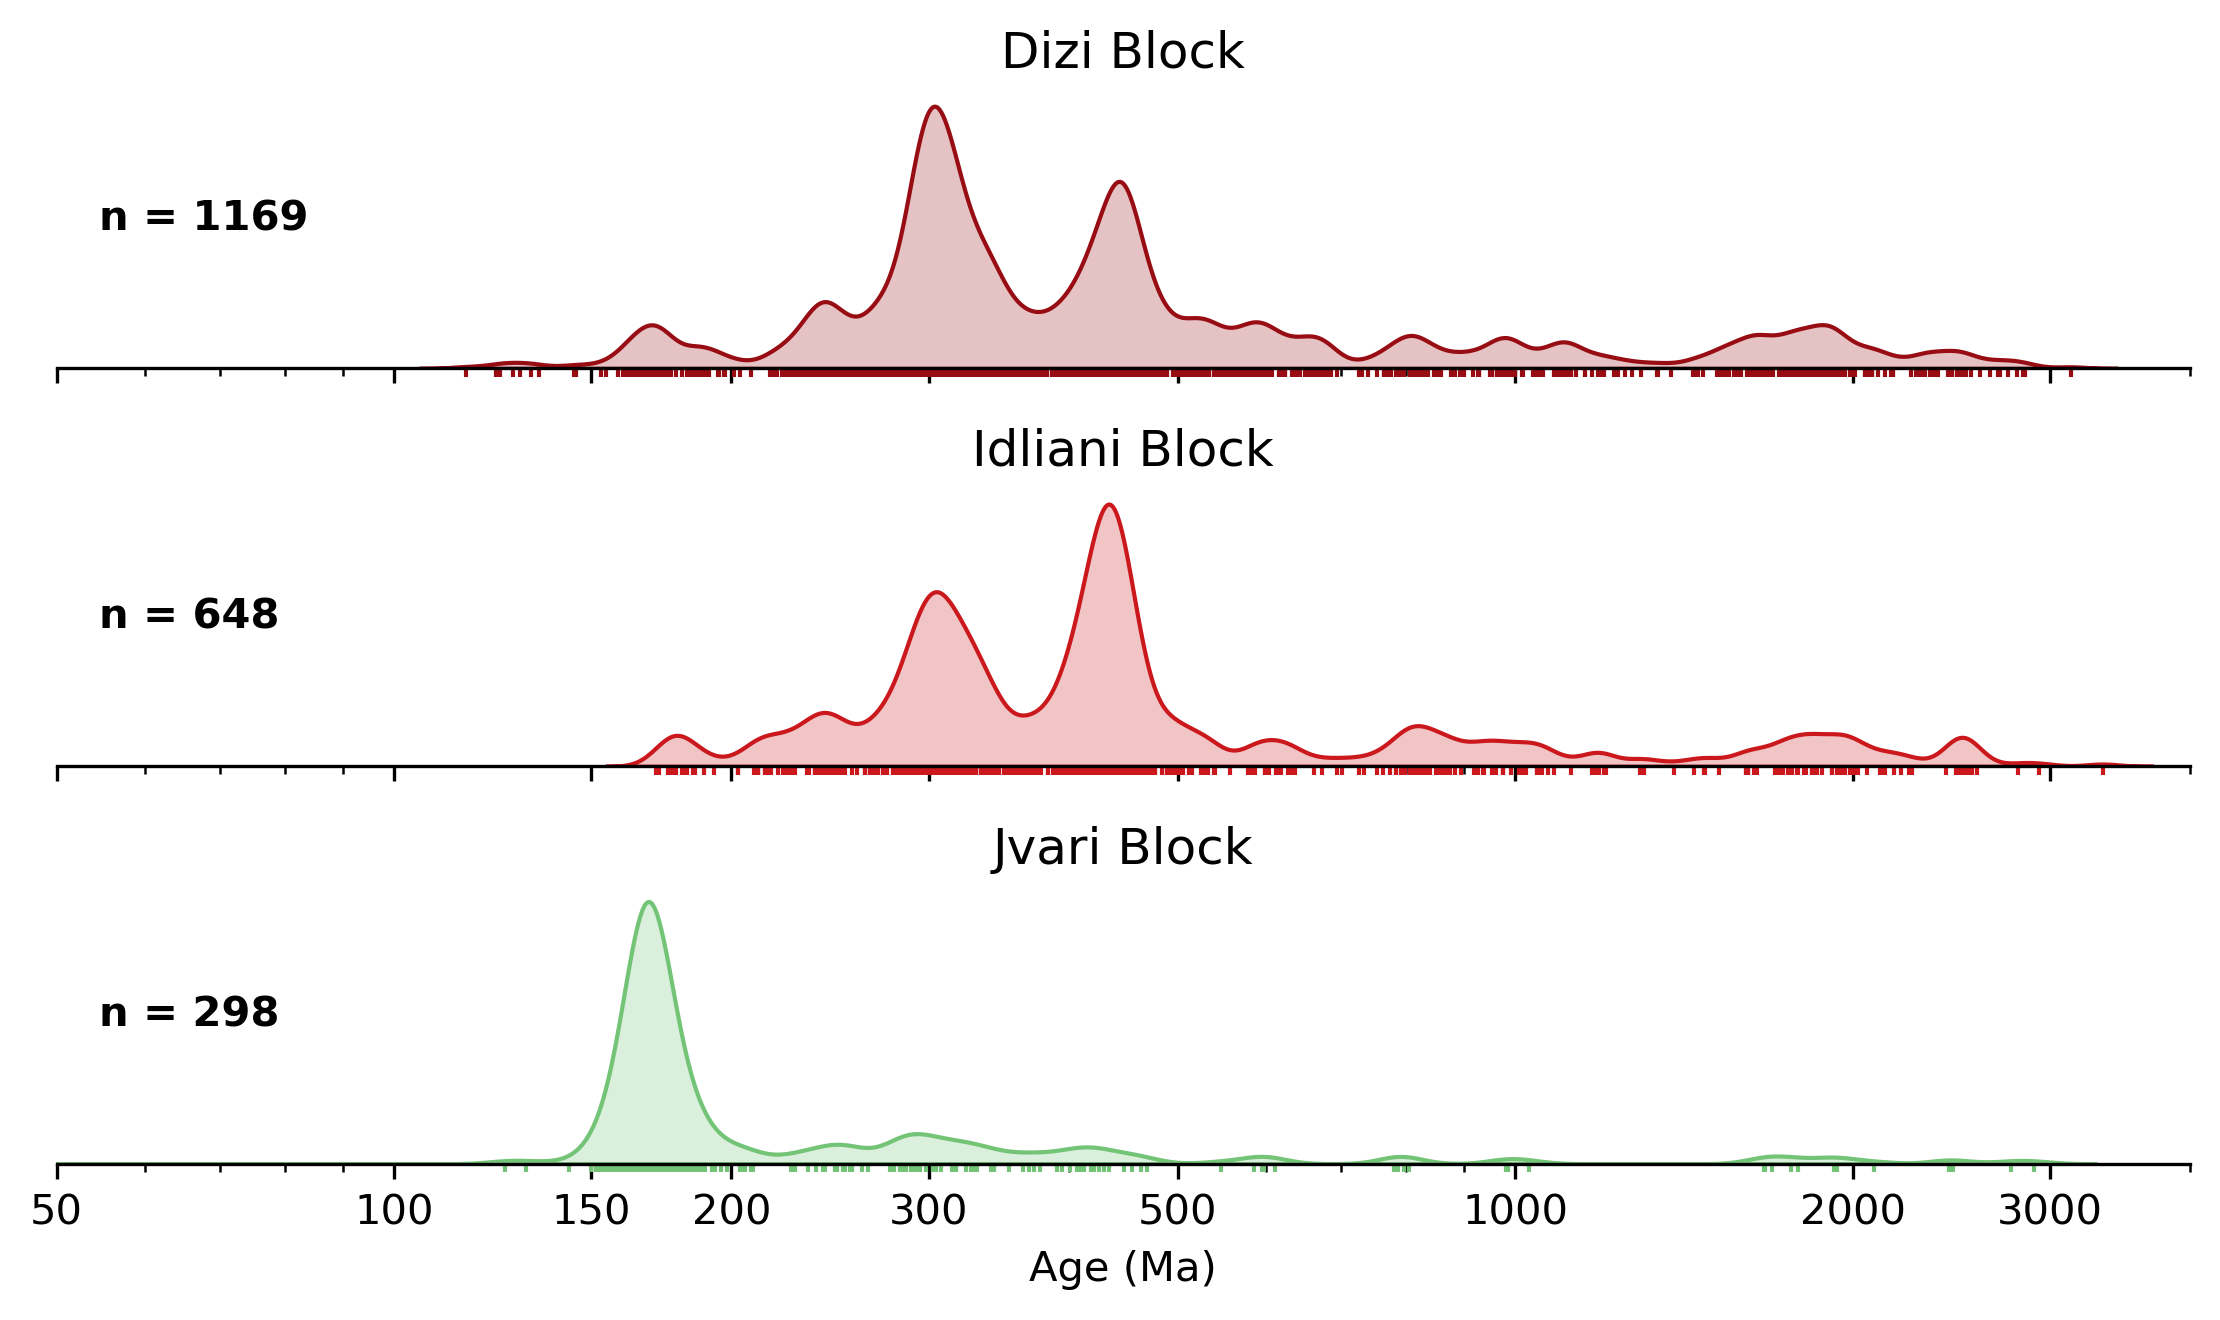

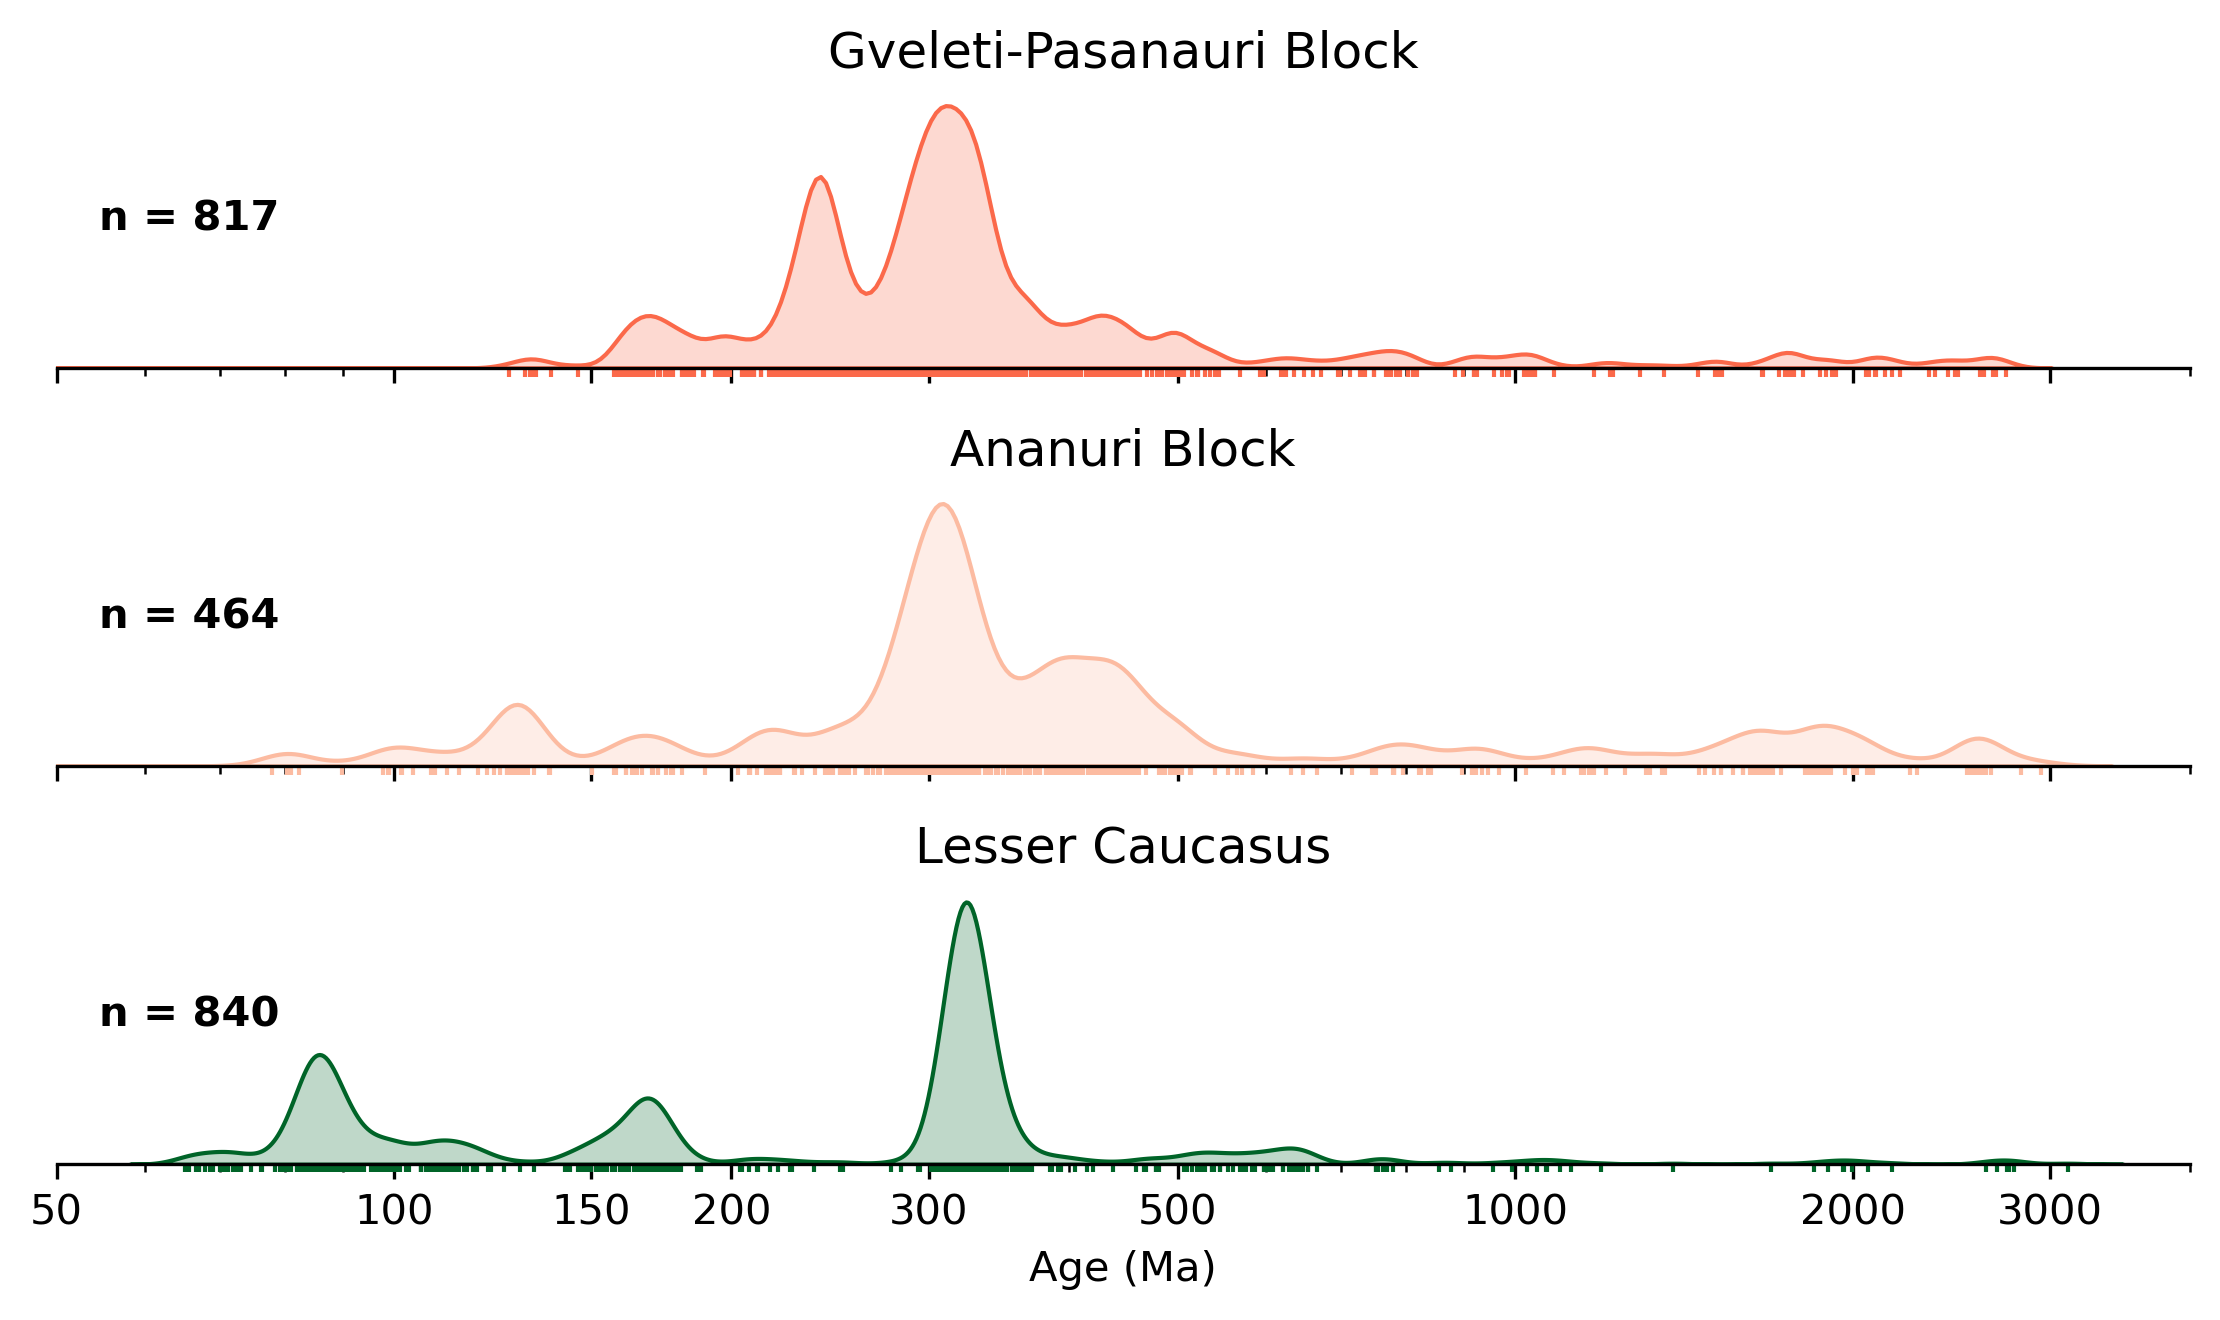

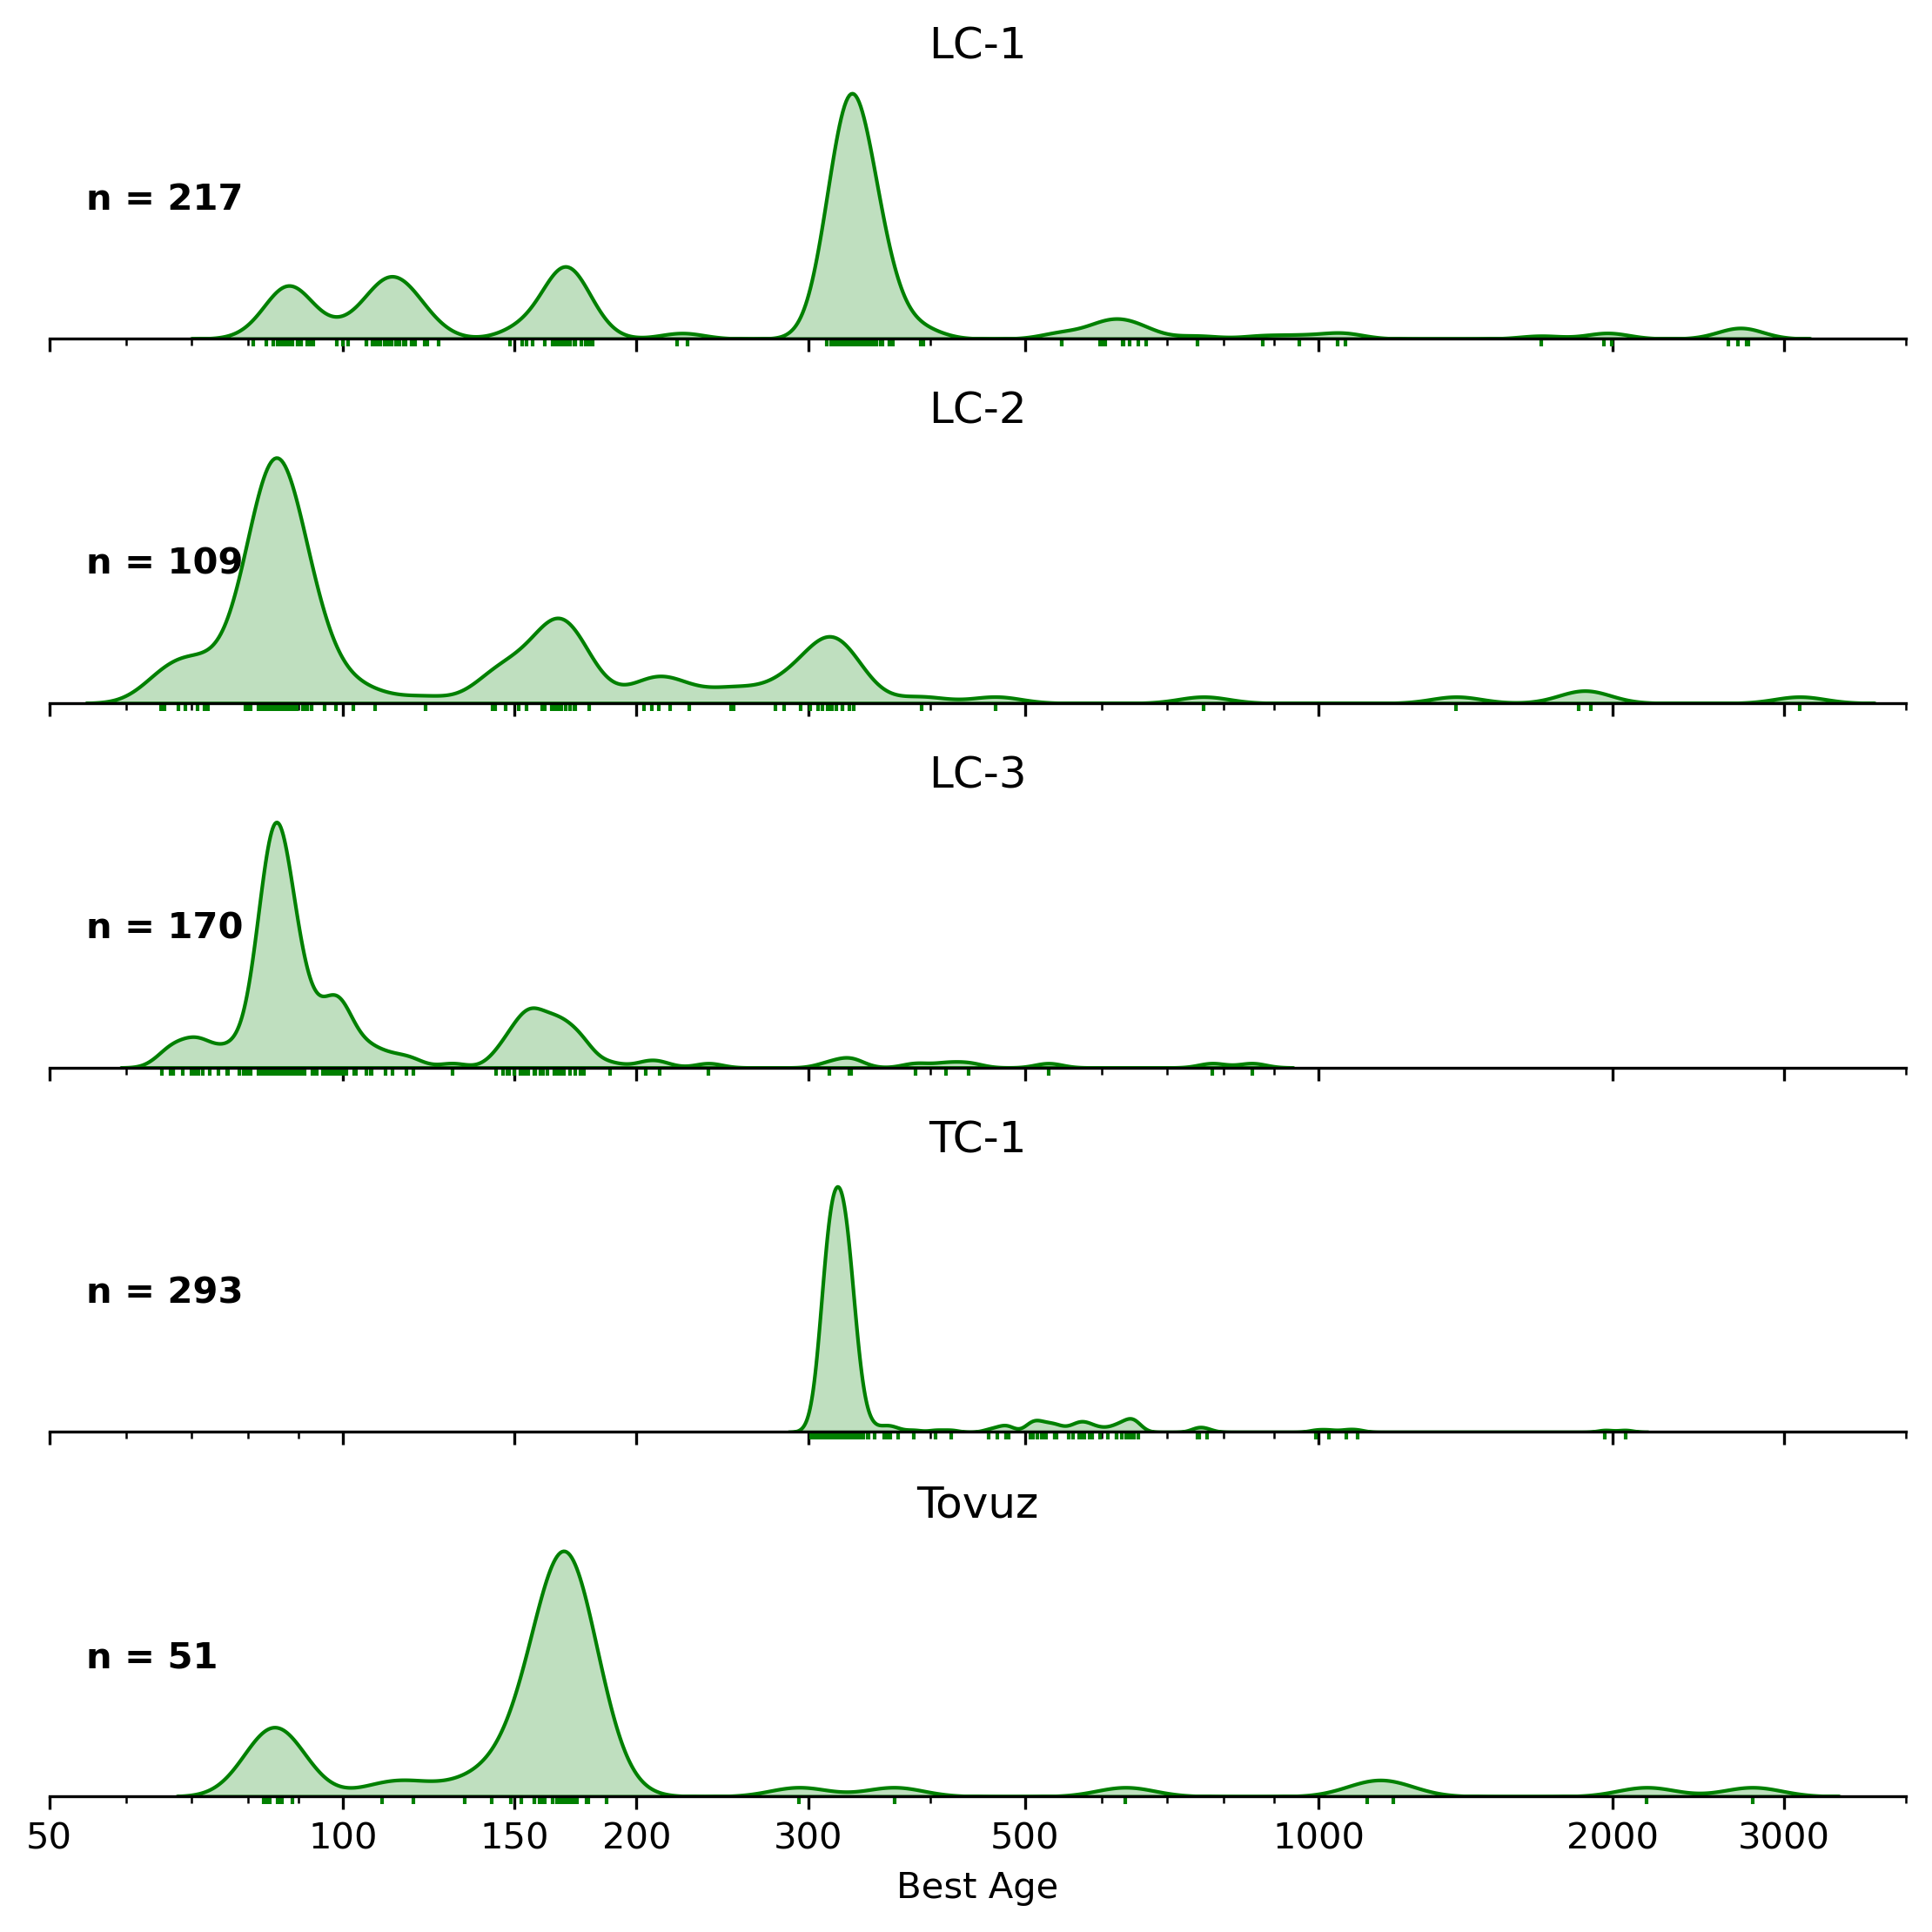

In [12]:
import matplotlib

reds = matplotlib.cm.get_cmap('Reds')
greens = matplotlib.cm.get_cmap('Greens')


dizi_names = ['NW-GC','N5','Khelra','WGC-2','SV2','SV8','SV7']
idliani_names = ['Khopuri','SV3','SV4']
jvari_names = ['SW-GC','WGC-3','SV6','SV5']
gvpas_names = ['K3','KZ1','KZ2','Tskhradzmula','CGC-1']
ana_names = ['KZ4','KZ3','KZ6','KZ5','CGC-2']

lc_names = ['LC-1','LC-2','LC-3','TC-1','Tovuz']

dizi_smps = [smp for smp in samples if smp.name in dizi_names]
idliani_smps = [smp for smp in samples if smp.name in idliani_names]
jvari_smps = [smp for smp in samples if smp.name in jvari_names]
gvpas_smps = [smp for smp in samples if smp.name in gvpas_names]
ana_smps = [smp for smp in samples if smp.name in ana_names]
lc_smps = [smp for smp in samples if smp.name in lc_names]

for smp in lc_smps:
    smp.color='green'
    smp.bestage = smp.bestage[smp.bestage>65]

lc_smps.sort(key=lambda x: x.name)

dizi = dz.composite(dizi_smps,name='Dizi Block')
idliani = dz.composite(idliani_smps,name='Idliani Block')
jvari = dz.composite(jvari_smps,name='Jvari Block')
gvpas = dz.composite(gvpas_smps,name='Gveleti-Pasanauri Block')
ana = dz.composite(ana_smps,name='Ananuri Block')
lc = dz.composite(lc_smps,name='Lesser Caucasus')

color_dict = {dizi:reds(0.9),idliani:reds(0.75),gvpas:reds(0.5),ana:reds(0.25),jvari:greens(0.5),lc:greens(0.9)}

blocks1 = [dizi,idliani,jvari]
blocks2 = [gvpas,ana,lc]
allblocks = blocks1+blocks2

for block in allblocks:
    block.color=color_dict[block]

plot_fault_block(blocks1,save=True,filename='sv_blocks.pdf',method=None,mda=False,bw_adjust=0.2,ticks=ticks)
plot_fault_block(blocks2,save=True,filename='kz_blocks.pdf',method=None,mda=False,bw_adjust=0.2,ticks=ticks)
plot_fault_block(lc_smps,save=True,filename='lc.pdf',method=None,mda=False,bw_adjust=0.2,ticks=ticks)


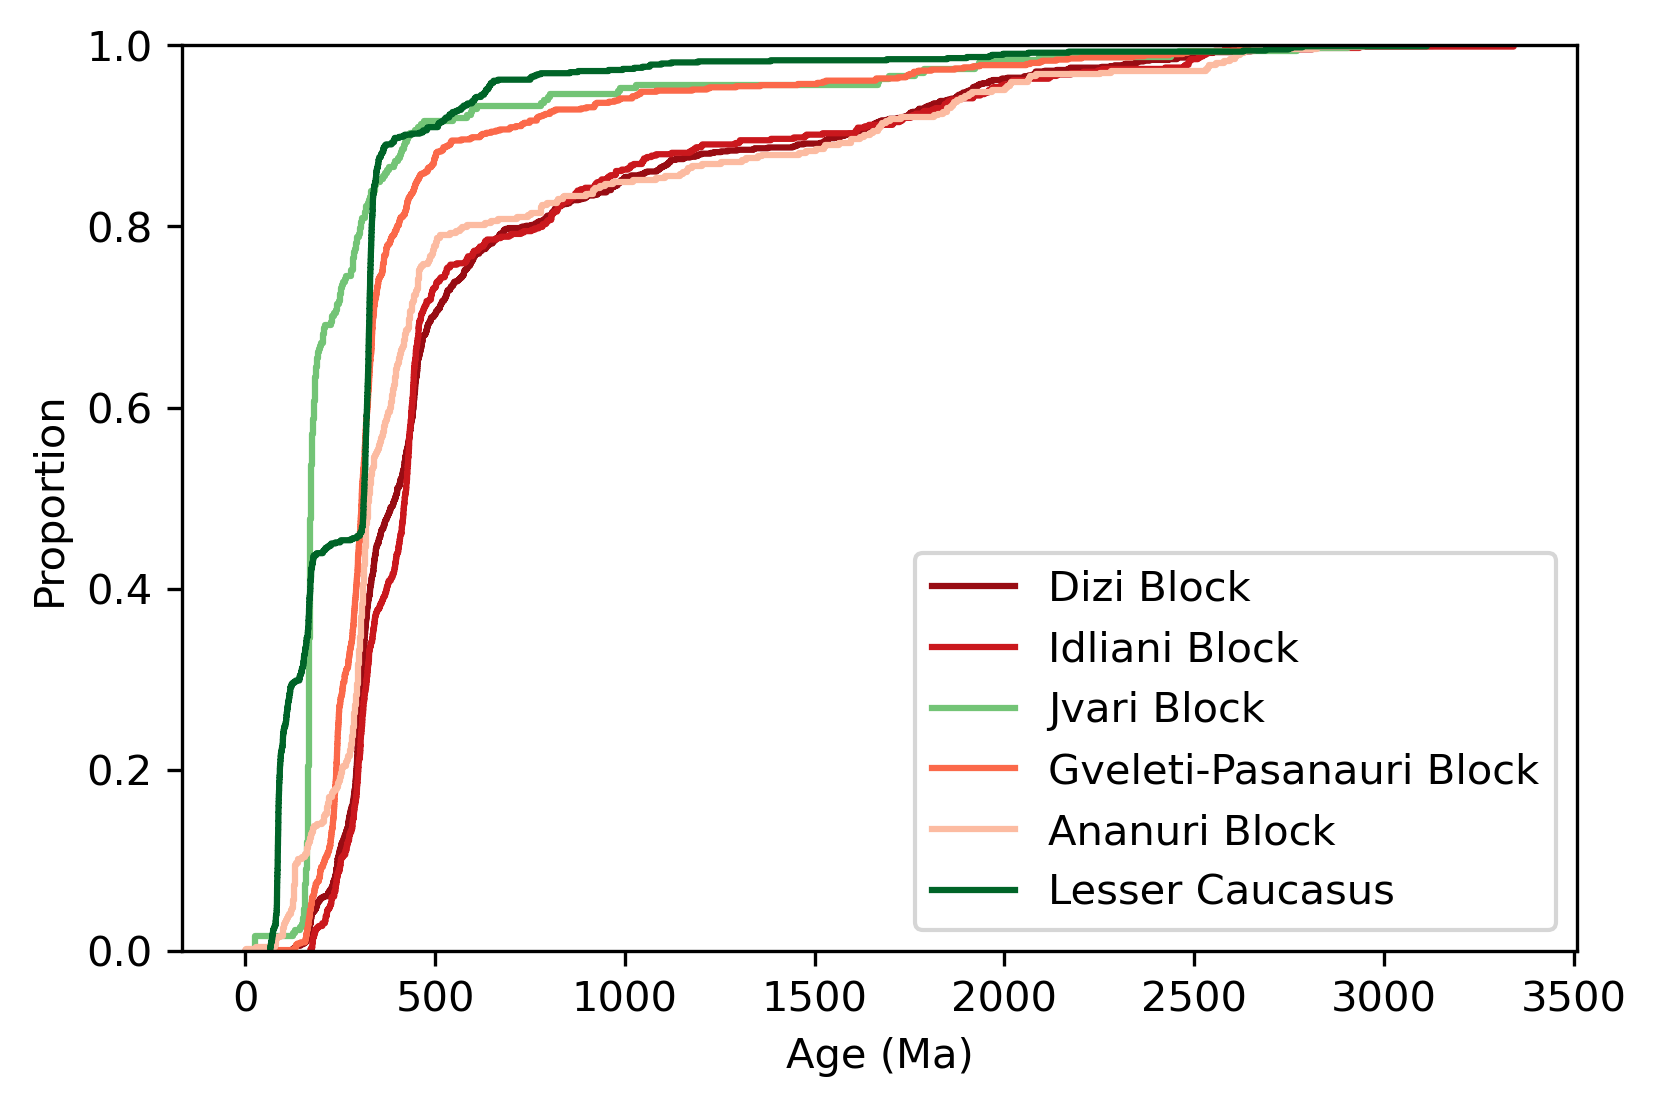

In [13]:
fig,ax = plt.subplots(1,dpi=300)
for smp in allblocks:
    smp.cad(ax=ax,color=color_dict[smp])

plt.legend()

fig.savefig('cad.pdf')
    

c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:559: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  comp.bestage = pd.Series()
c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:564: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp.bestage = comp.bestage.append(sample.bestage)
c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:564: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp.bestage = comp.bestage.append(sample.bestage)
c:\Users\dyvas\git\dz-caucasus\geoscripts\dz\dz.py:564: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  comp.bestage = comp.bestage.append(sample.bestage)
c:\Users\dyvas\git\dz-cau

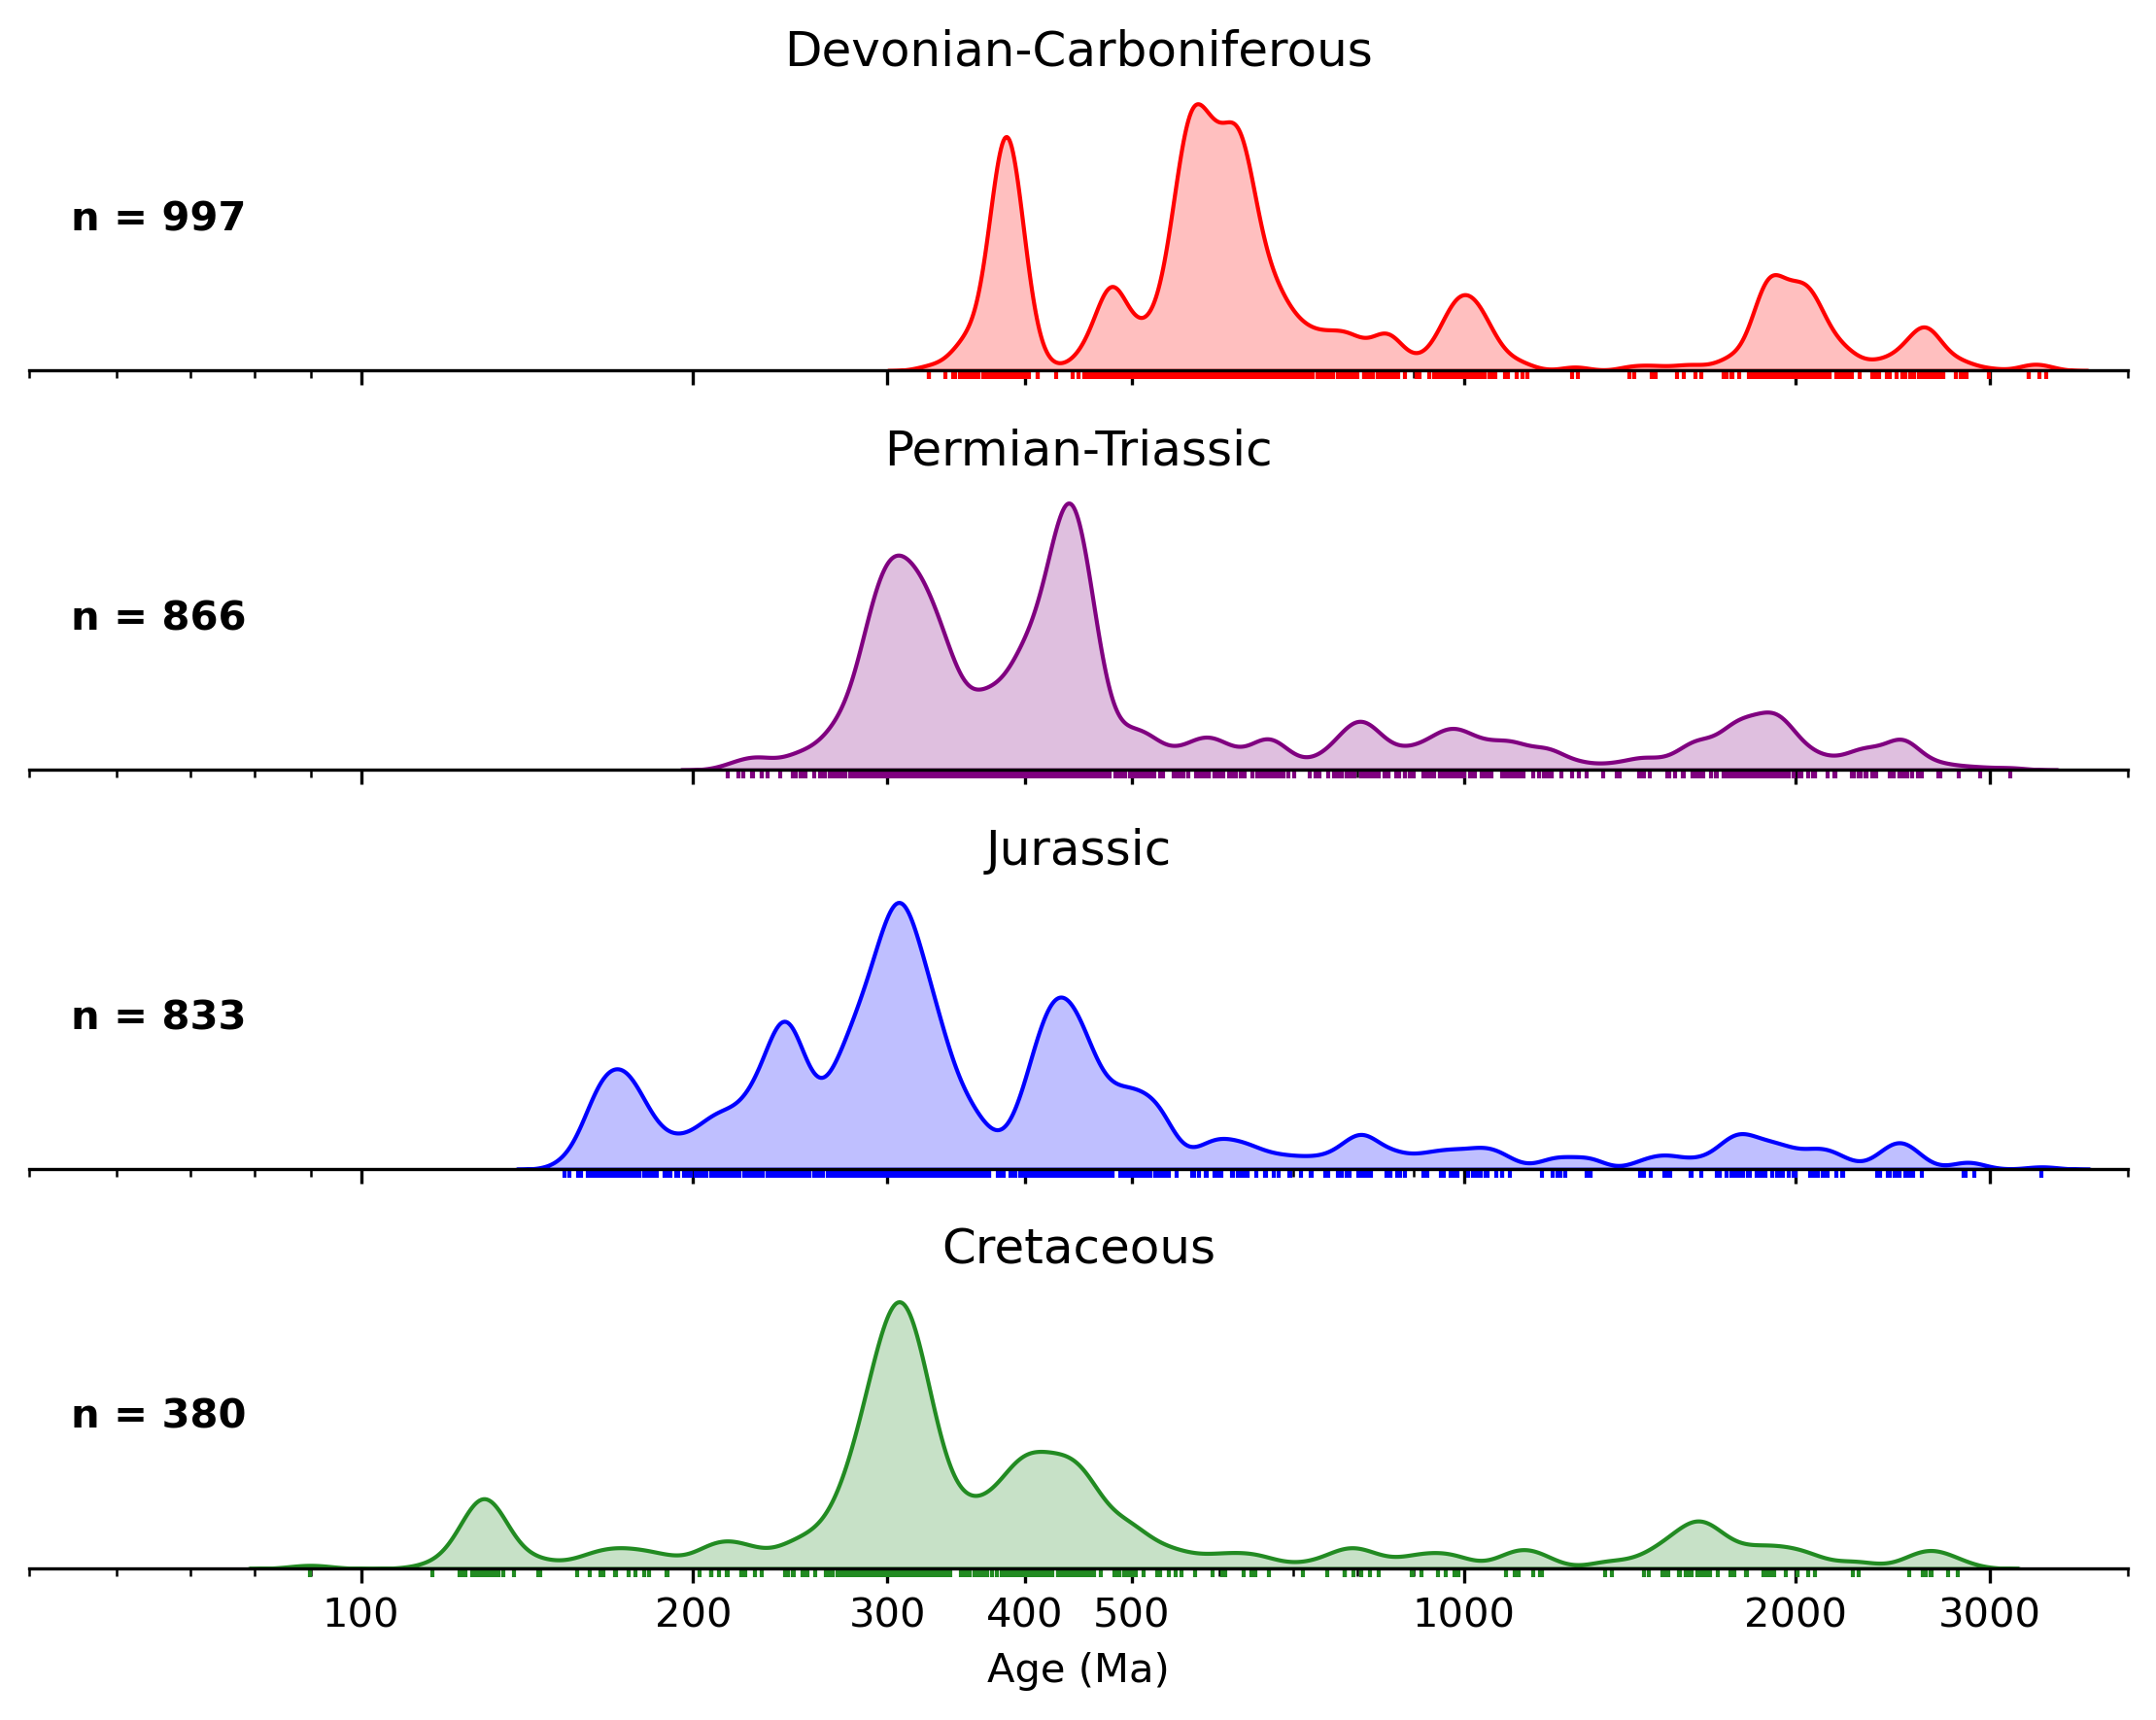

In [14]:
devcar = dz.composite(pz,name='Devonian-Carboniferous',color='red')
ptr = dz.composite(tr,name='Permian-Triassic',color='purple')

j_smps = [smp for smp in samples_new if smp.name in ['KZ1','KZ2','SV4','SV5','SV6','SV7','NW-GC','K3']]
j = dz.composite(j_smps,color='blue',name='Jurassic')

k_smps = [smp for smp in samples_new if smp.name in ['SV8','KZ3','KZ4','KZ5','KZ6']]
k = dz.composite(k_smps,color='forestgreen',name='Cretaceous')

plot_fault_block([devcar,ptr,j,k],save=True,filename='age_dep.pdf',mda=False,method=None,bw_adjust=0.2)

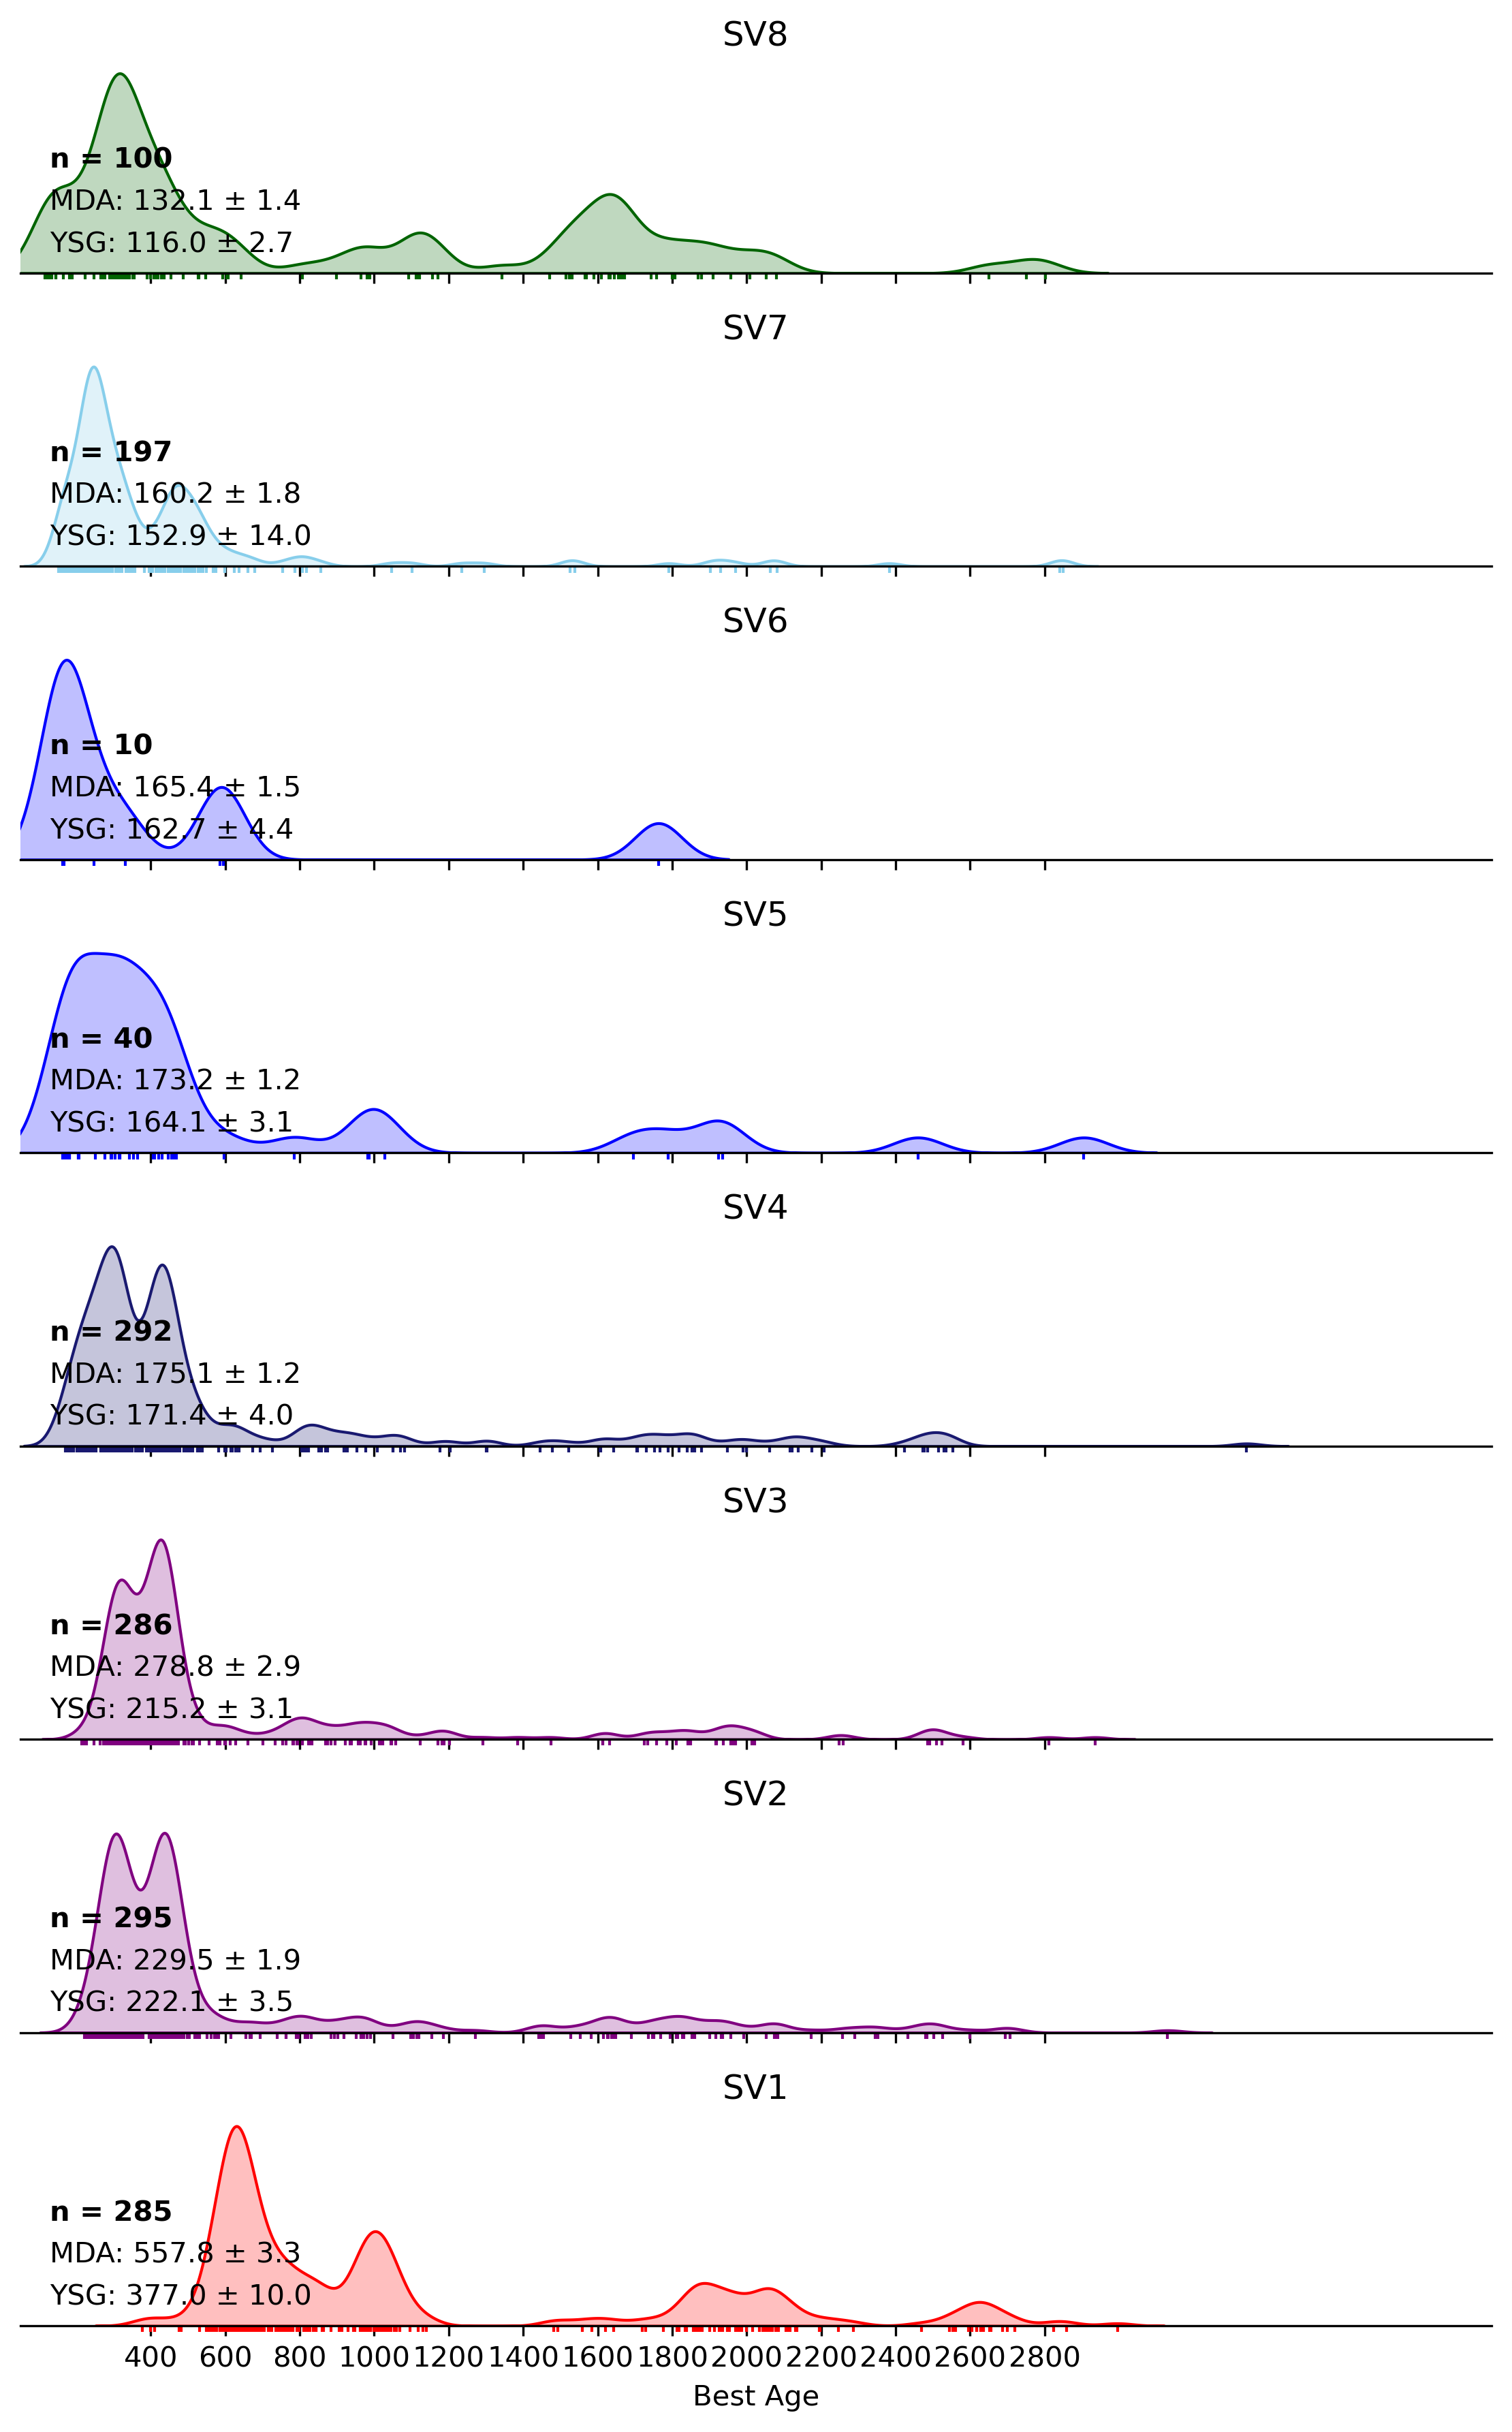

In [15]:
# Look at old populations
plot_fault_block(sv_samples,save=False,method=None,bw_adjust=0.2,ticks=np.arange(400,3000,200),
log_scale=False)

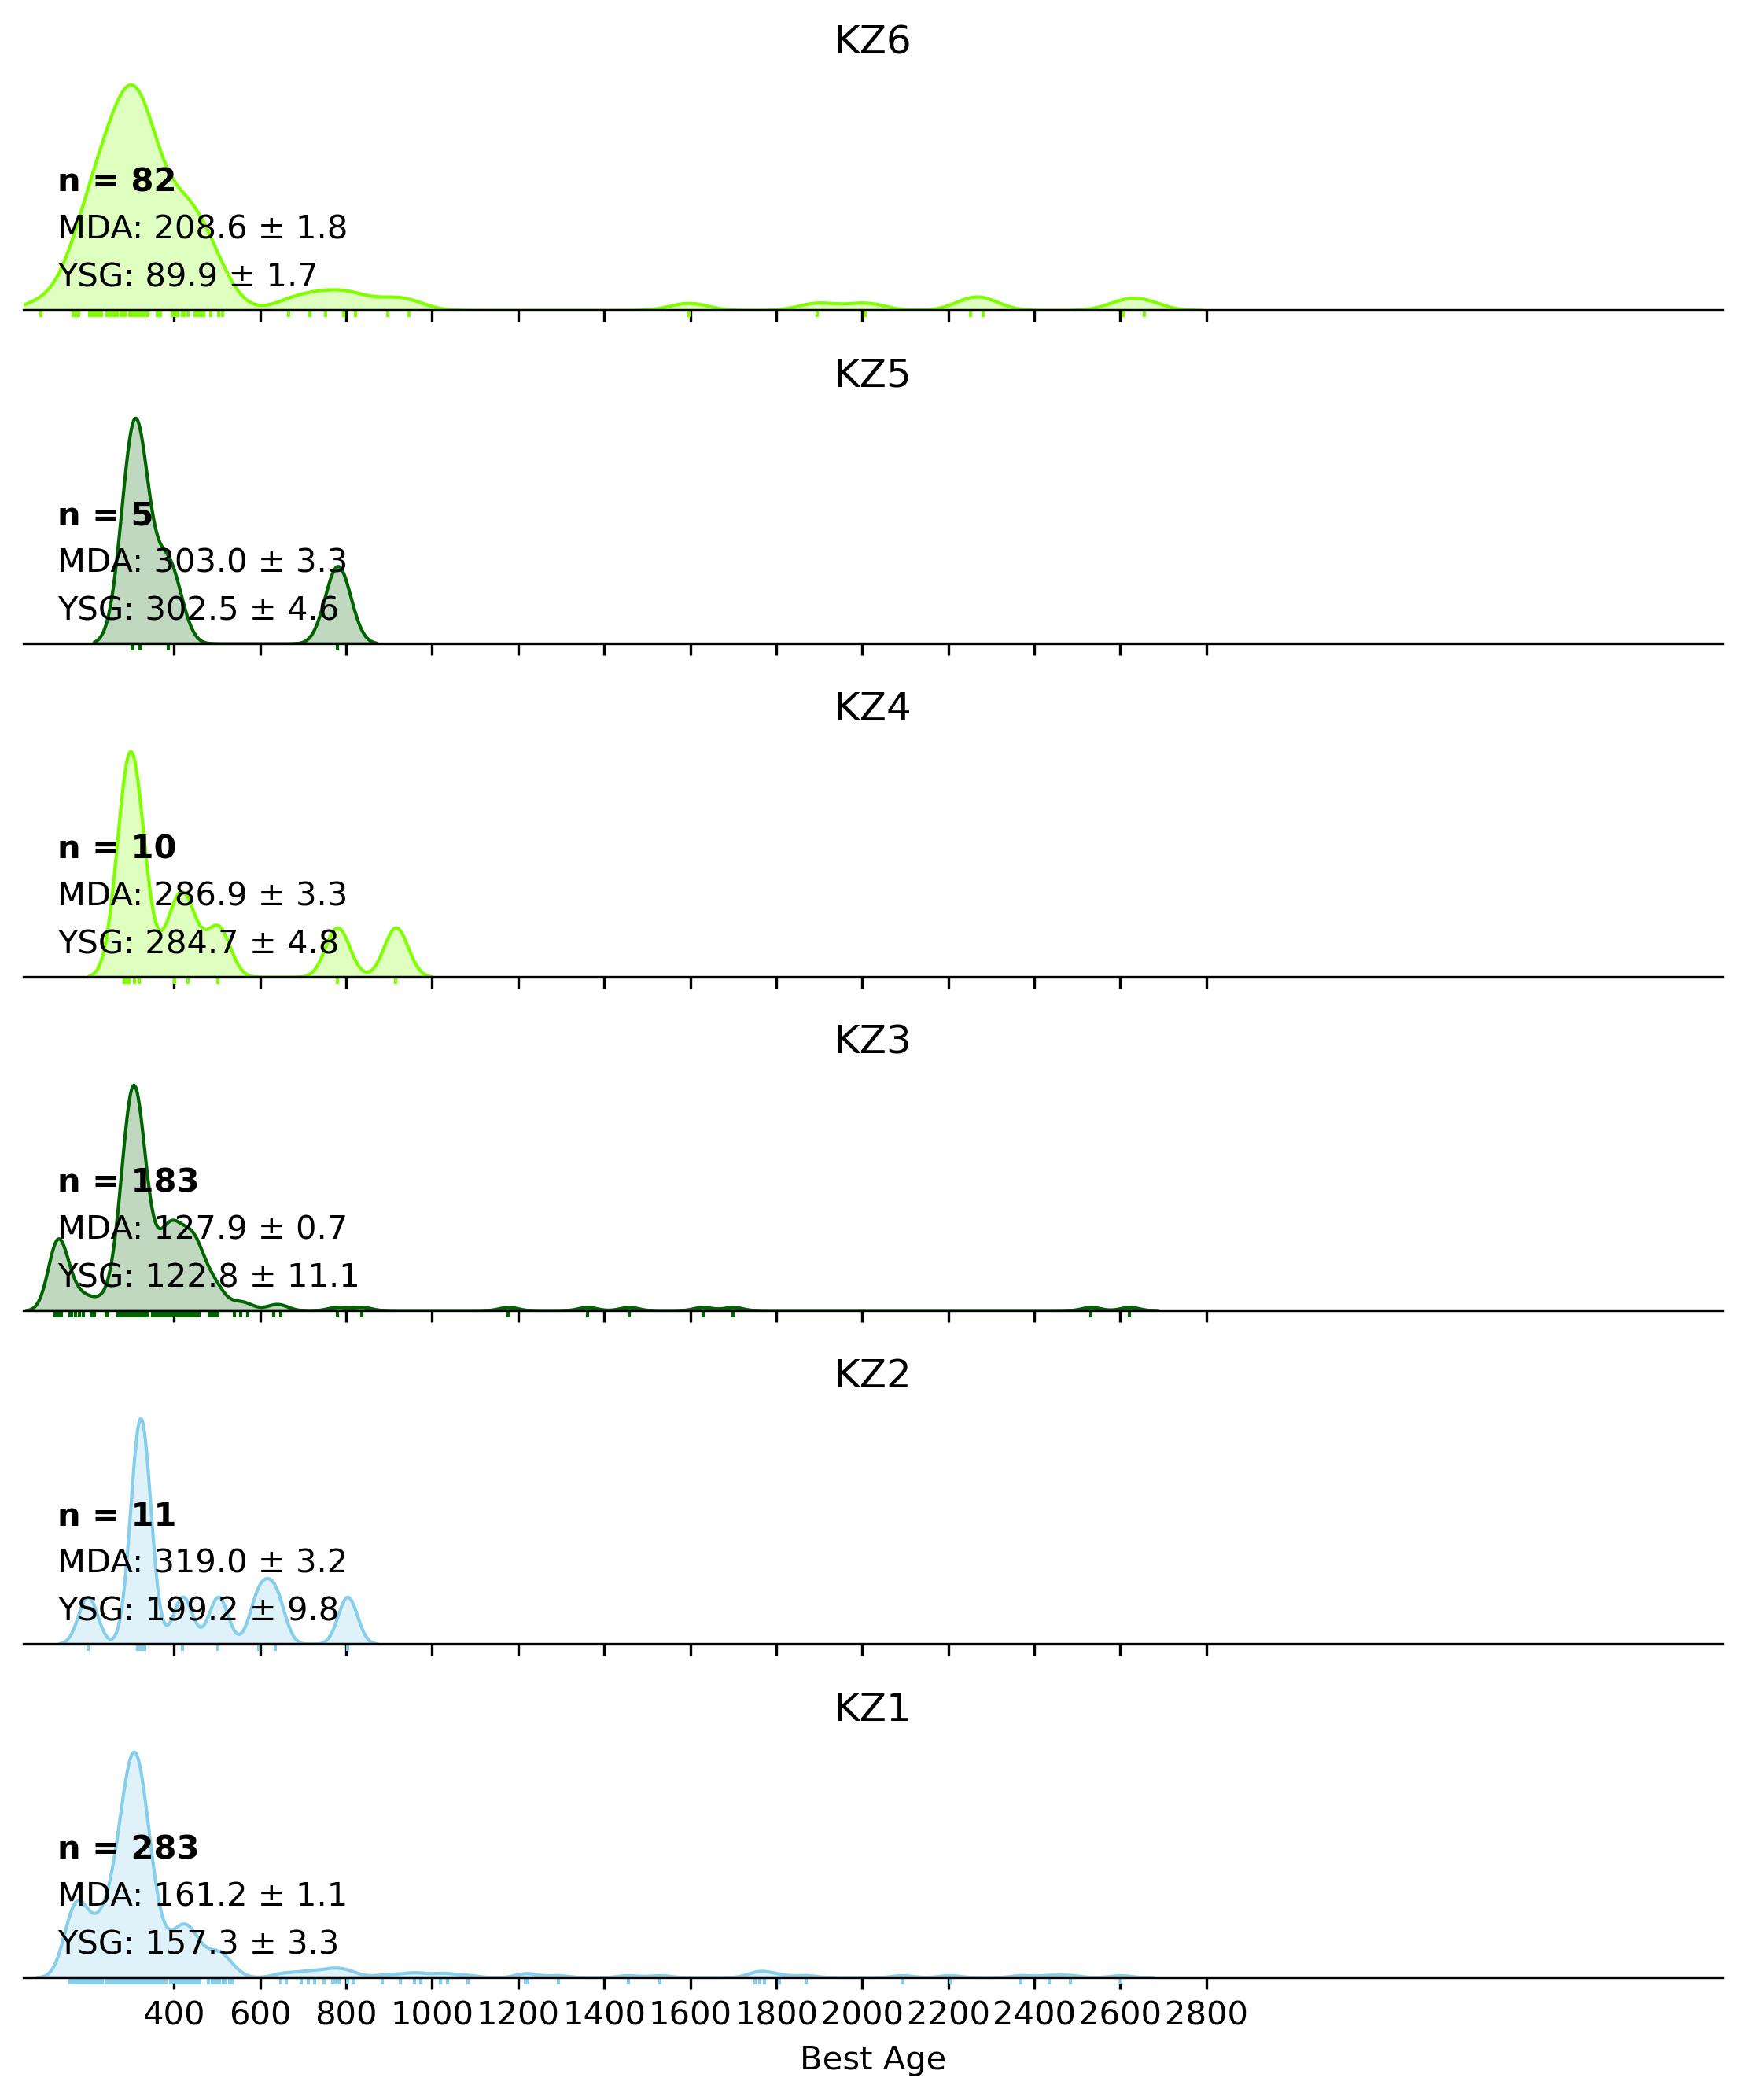

In [16]:
plot_fault_block(kz_samples,save=False,method=None,bw_adjust=0.2,ticks=np.arange(400,3000,200),
log_scale=False)

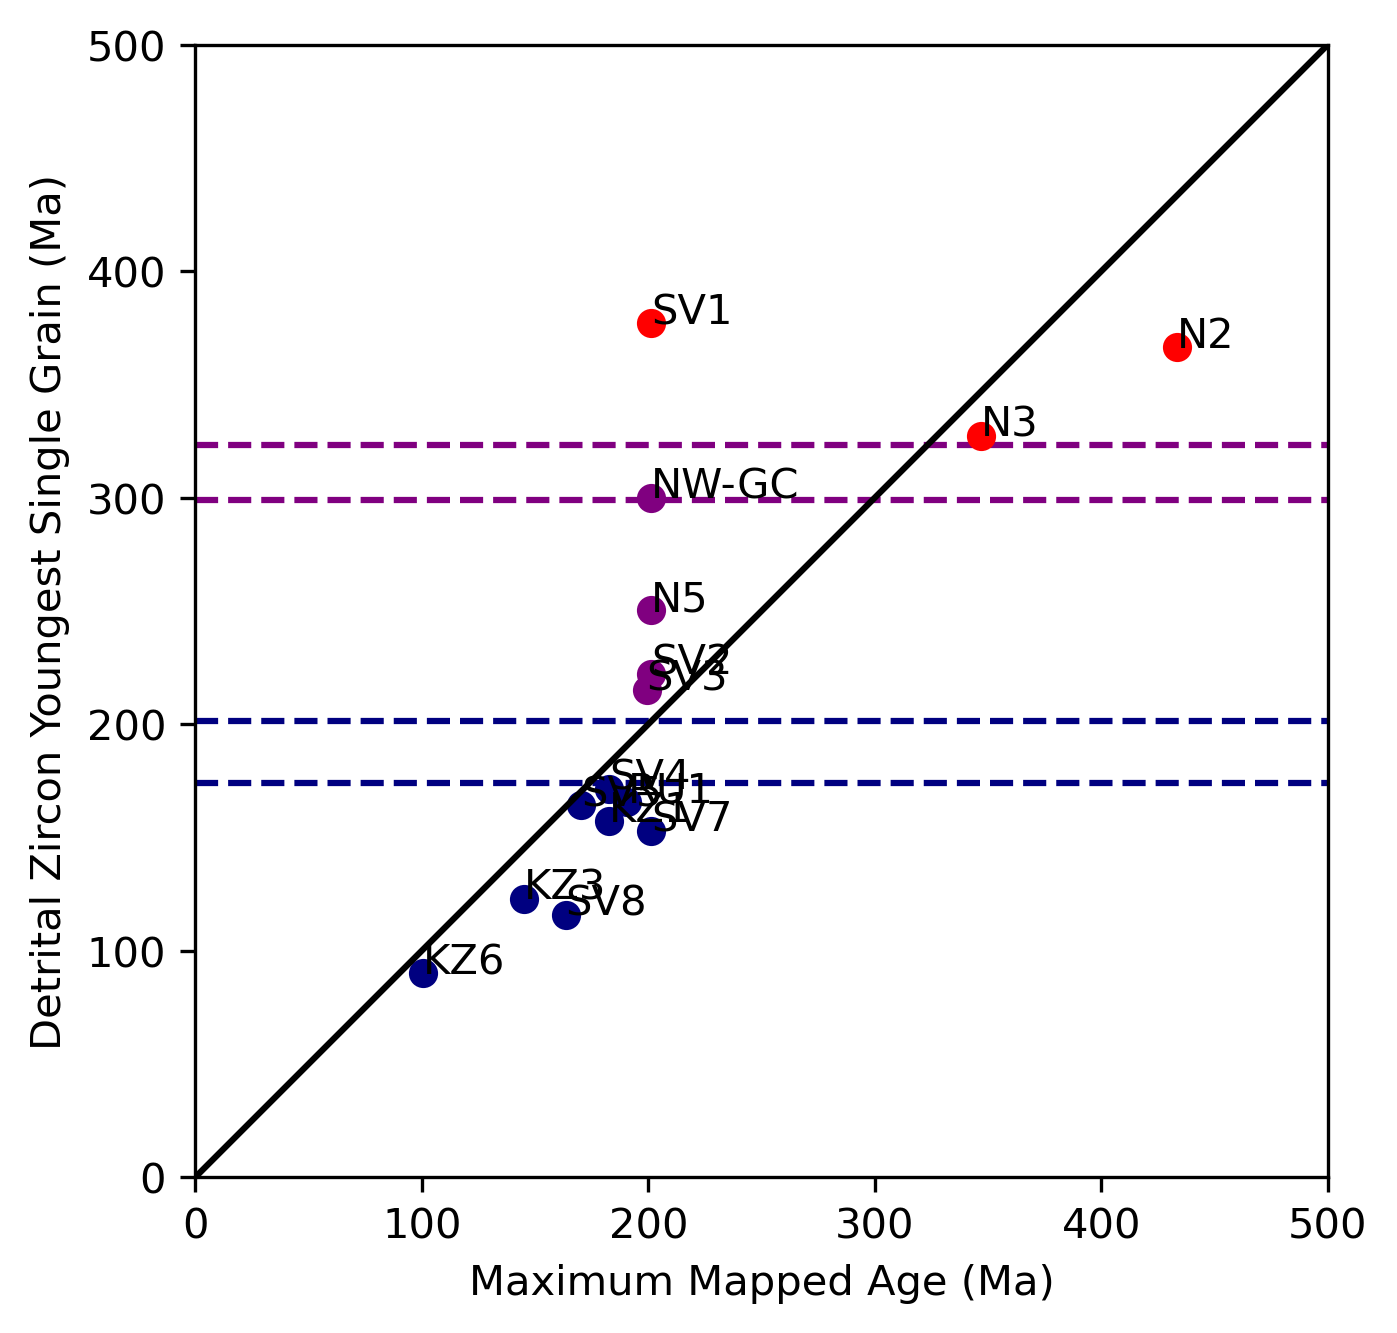

In [17]:
# Plot MDA vs. mapped age

fig, ax = plt.subplots(1,dpi=300,figsize=(5,5))
ax.set_aspect('equal')
ax.plot(np.arange(0,1000,100),np.arange(0,1000,100),color='black')
ax.set_xlabel('Maximum Mapped Age (Ma)')
ax.set_ylabel('Detrital Zircon Youngest Single Grain (Ma)')
ax.set_xlim(0,500)
ax.set_ylim(0,500)

ejmin = 174.1
ejmax = 201.3

lcarbmin = 298.9
lcarbmax = 323.2

ax.axhline(ejmax,linestyle='--',color='navy',zorder=0)
ax.axhline(ejmin,linestyle='--',color='navy',zorder=0)
ax.axhline(lcarbmax,linestyle='--',color='purple',zorder=0)
ax.axhline(lcarbmin,linestyle='--',color='purple',zorder=0)

for smp in tr2+pz2:
    smp.ysg = np.min(smp.bestage)

for smp in sv_samples+kz_samples+tr2+pz2+ru:
    if smp.bestage.count()>15:
        x = smp.mapped_age[1]
        y = smp.ysg

        ej_grains = smp.bestage[(smp.bestage<ejmax)&(smp.bestage>ejmin)]
        lcarb_grains = smp.bestage[(smp.bestage<lcarbmax)&(smp.bestage>lcarbmin)]

        if (ej_grains.count()>0)&(lcarb_grains.count()>0):
            plot_color = 'navy'
        elif lcarb_grains.count()>0:
            plot_color='purple'
        else:
            plot_color='red'

        ax.scatter(x,y,label=smp.name,color=plot_color)
        ax.annotate(smp.name,(x,y))

fig.savefig('mda_old_maxmapped.pdf')

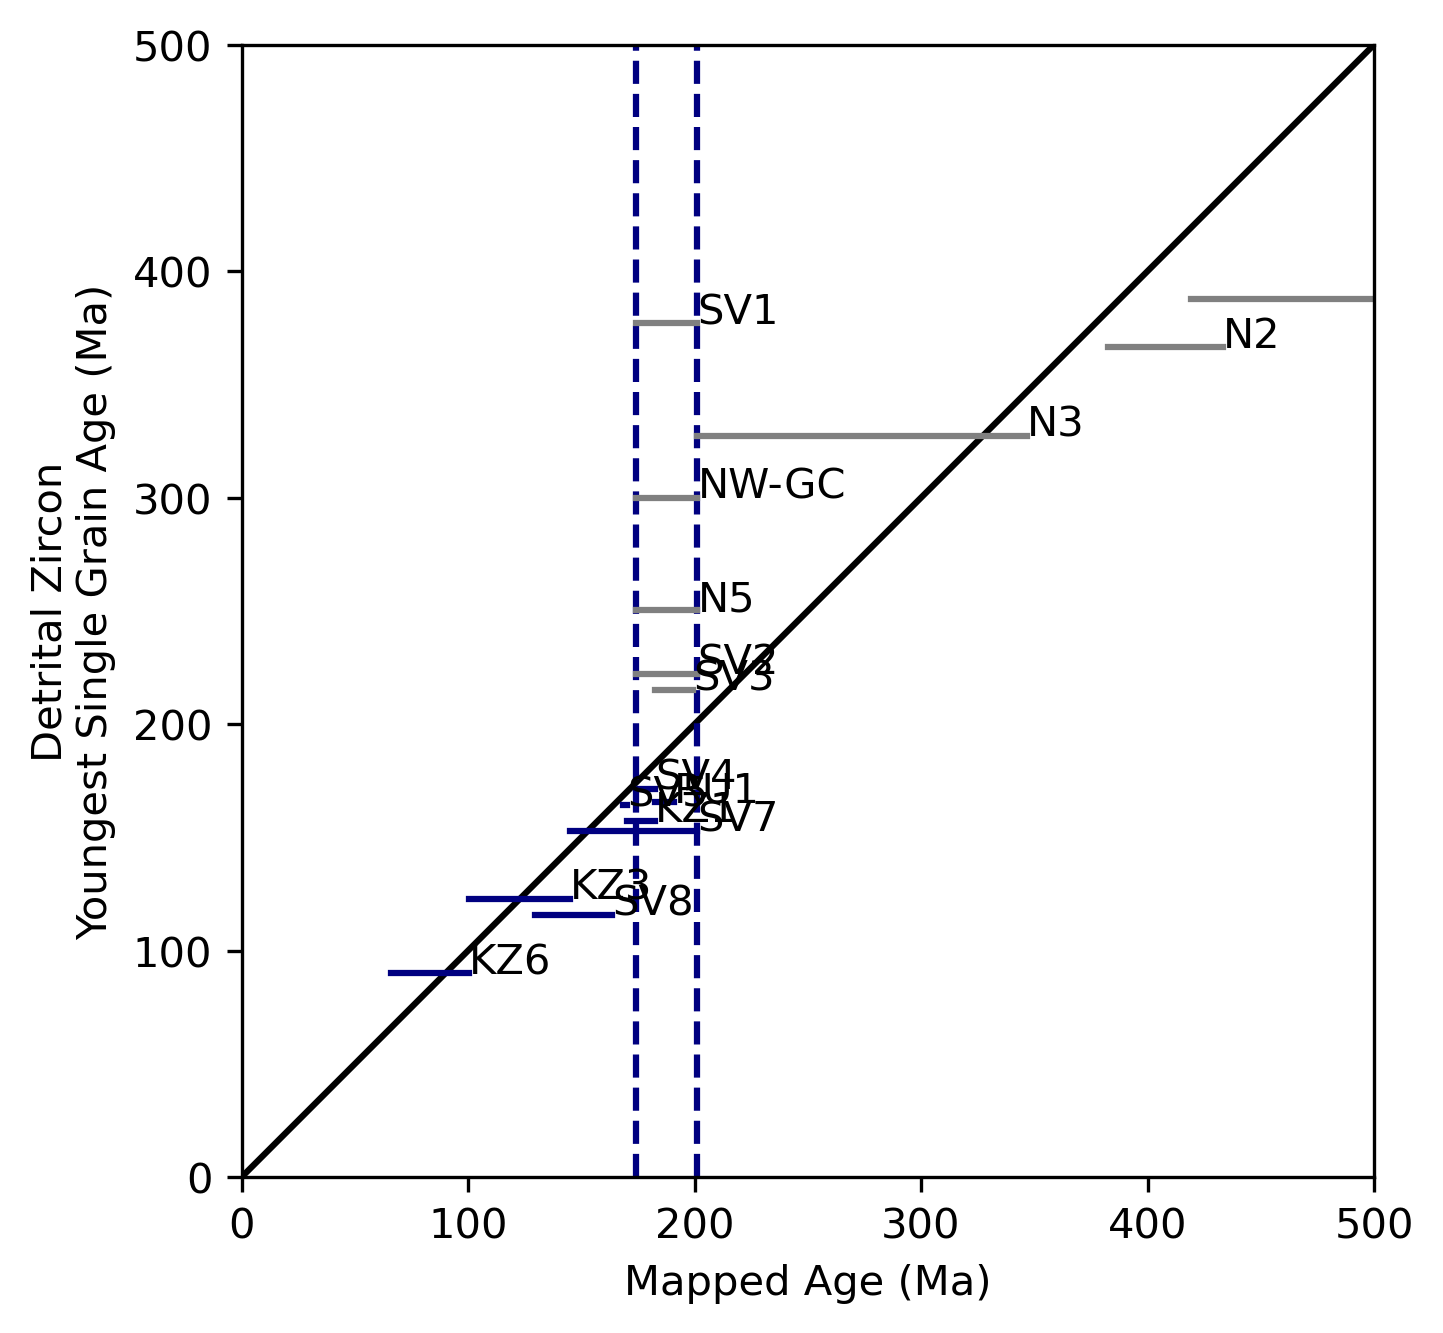

In [18]:
# Plot MDA vs. mapped age

fig, ax = plt.subplots(1,dpi=300,figsize=(5,5))
ax.set_aspect('equal')
ax.plot(np.arange(0,1000,100),np.arange(0,1000,100),color='black')
ax.set_xlabel('Mapped Age (Ma)')
ax.set_ylabel('Detrital Zircon\nYoungest Single Grain Age (Ma)')
ax.set_xlim(0,500)
ax.set_ylim(0,500)

ejmin = 174.1
ejmax = 201.3
ax.axvline(ejmin,linestyle='--',color='navy')
ax.axvline(ejmax,linestyle='--',color='navy')

for smp in tr2+pz2:
    smp.ysg = np.min(smp.bestage)

for smp in sv_samples+kz_samples+tr2+pz2+ru:
    if smp.bestage.count()>15:
        xmin = smp.mapped_age[0]
        xmax = smp.mapped_age[1]
        y = smp.ysg

        ej_grains = smp.bestage[(smp.bestage<ejmax)*smp.bestage>ejmin]

        if ej_grains.count()>0:
            plot_color = 'navy'
        else:
            plot_color='gray'

        ax.plot([xmin,xmax],[y,y],color=plot_color)
        ax.annotate(smp.name,(xmax,y))

        fig.savefig('mda_old.pdf')

4      525.364212
9      512.450705
16     512.917270
25     454.053501
27     375.907175
31     520.021400
33     518.723459
34     520.214214
35     564.274430
39     262.827726
44     531.677284
46     200.271247
66     542.044427
73     530.044240
75     486.057934
80     521.847961
82     500.293425
87     535.769488
90     394.206229
92     550.386994
96     536.630056
97     314.569822
101    548.664637
104    526.548363
105    212.234629
107    527.461706
109    496.149433
110    526.851170
112    536.974142
121    497.192326
131    583.649066
134    583.728191
141    460.522785
149    408.135864
154    529.198305
159    525.340348
173    552.824885
Name: Best Age, dtype: float64


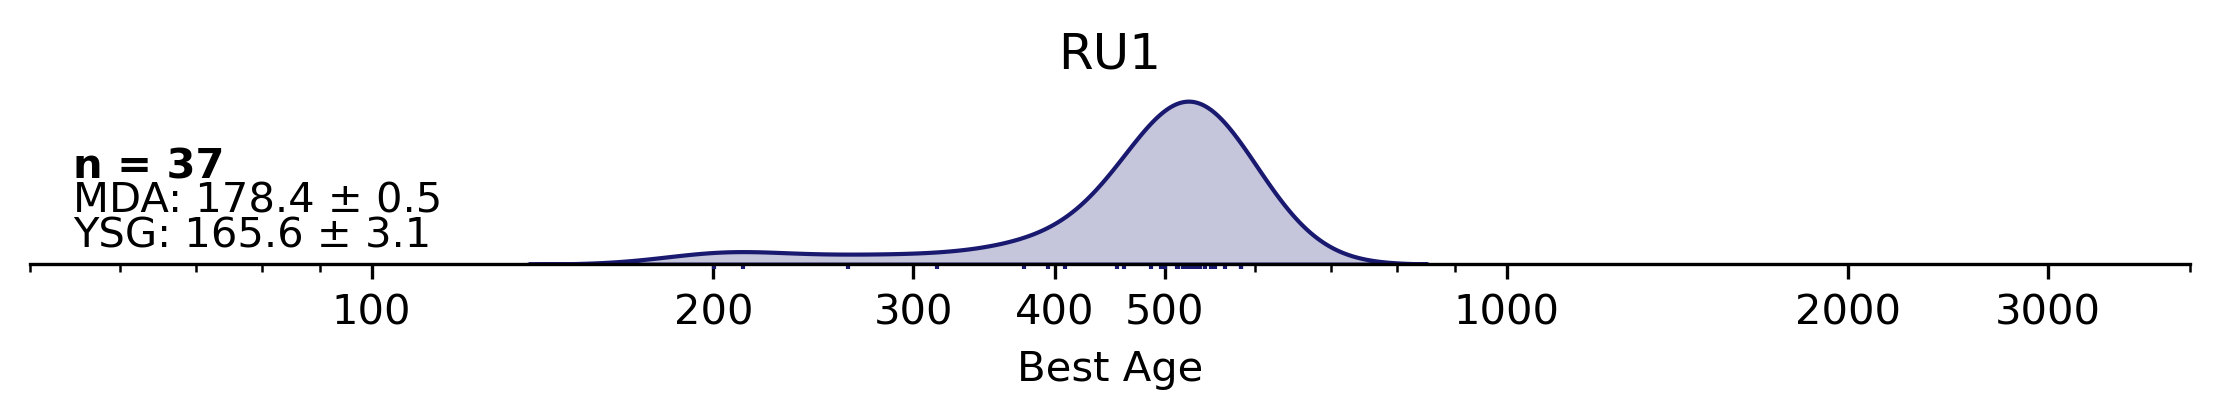

In [19]:
ru_culled = ru[0].bestage[ru[0].bestage>200]

print(ru_culled)

ru[0].bestage = ru_culled

plot_fault_block(ru)
